## Initial Data Understanding and Preprocessing


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Load the data
df = pd.read_excel(r"input_data\Final_HB_featureData.xlsx")


df.drop(columns= ["File Name",'style'],inplace =True)
# Display basic information about the dataset
# display(data.head(), data.info(), data.describe(), data.shape)


# Check the shape of the data
print(f"Dataset shape: {df.shape}")

# Display basic information
print(df.info())

# Check summary statistics
print(df.describe())



Dataset shape: (64, 119)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Columns: 119 entries, bag_height to max_qty_sold_at_store
dtypes: bool(1), float64(11), int64(70), object(37)
memory usage: 59.2+ KB
None
       bag_height  bag_width  top_opening_width  gusset_width  \
count   64.000000  64.000000          64.000000     64.000000   
mean    17.001562  22.662500          22.573437      8.115625   
std      6.523863   7.550854           7.976259      4.042482   
min      7.700000  10.300000          10.300000      0.000000   
25%     11.875000  17.950000          17.725000      5.650000   
50%     16.000000  21.500000          20.750000      7.600000   
75%     21.300000  25.575000          25.575000     10.500000   
max     30.500000  45.000000          45.700000     17.500000   

       handle_drop_length  long_strap_drop_length  logo_size  logo_visibility  \
count           60.000000               61.000000  63.000000        64.000000   
mean            11.

### Data Cleaning and Preparation


In [102]:

### 3.3 Identify and Remove Constant Features

# Identify features with only one unique value
constant_features = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_features.append(col)

print(f"Found {len(constant_features)} constant features:")
print(constant_features)

# Remove constant features
df = df.drop(columns=constant_features)
print(f"\nDataset shape after removing constant features: {df.shape}")

Found 29 constant features:
['limited_edition', 'colorblock_design', 'quilted_pattern', 'luggage_sleeve', 'water_bottle_pocket', 'built_in_mirror', 'dust_bag_included', 'monogram_option', 'key_leash', 'twist_lock', 'bow_element', 'floral_elements', 'animal_print', 'stripe_pattern', 'woven_elements', 'pearl_elements', 'pleat_count', 'kisslock_frame', 'collapsible_gusset', 'pen_loops', 'hidden_snap', 'gender', 'article_cat_ind', 'licensed', 'size_code', 'article_type', 'factory_store_type', 'brandcode', 'fiscalyear']

Dataset shape after removing constant features: (64, 90)


In [103]:
# Check for missing values
missing_values = df.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# # Handle missing values for numeric columns
# numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# for col in numeric_cols:
#     if df[col].isnull().sum() > 0:
#         # Replace with median for numeric columns
#         df[col] = df[col].fillna(df[col].median())

# Focus on key sales metrics
sales_cols = ['net_sales_qty_sum', 'net_sales_amt_lcl_sum', 'max_qty_sold_at_store']

# Remove rows with negative sales values (likely returns or adjustments)
df = df[df['net_sales_qty_sum'] >= 0]

# Create a new feature for price per item
df['price_per_item'] = df['net_sales_amt_lcl_sum'] / df['net_sales_qty_sum'].replace(0, np.nan)

Columns with missing values:
handle_drop_length         4
long_strap_drop_length     3
logo_size                  1
material_type_x            2
opener_design              1
opener_material            7
leather_texture           16
hardware_color             5
closure_type               2
silhouette_type            1
bag_shape                  2
color                     34
interior_lining            3
strap_type                11
strap_connector            8
edge_finishing             9
embellishment             31
stitching_density          1
top_handle_style          40
logo_placement             8
logo_style                 9
logo_type                  8
finish_type               15
material                   7
material_type_y           17
collaboration             64
dtype: int64


In [104]:
textual_features = [
    'material_type_x', 'opener_design', 'opener_material', 'leather_texture',
    'hardware_color', 'closure_type', 'silhouette_type', 'bag_shape', 'color',
    'interior_lining', 'strap_type', 'strap_connector', 'edge_finishing', 'embellishment',
    'bottom_structure', 'convertibility', 'limited_edition', 'signature_pattern',
    'colorblock_design', 'quilted_pattern', 'water_resistance', 'corner_protection',
    'bottom_feet', 'hangtag_presence', 'chain_detail', 'turnlock_hardware', 'removable_strap',
    'adjustable_strap', 'laptop_compatibility', 'crossbody_option', 'shoulder_option',
    'hand_carry_option', 'backpack_option', 'wristlet_option', 'wallet_function',
    'phone_compatibility', 'tablet_compatibility', 'luggage_sleeve', 'water_bottle_pocket',
    'ease_of_access', 'novelty_shape', 'built_in_mirror', 'eco_friendly_material',
    'dust_bag_included', 'monogram_option', 'key_leash', 'snap_button_closure',
    'charm_attachment_point', 'hidden_pocket', 'top_handle_style', 'logo_placement',
    'logo_style', 'logo_type', 'twist_lock', 'exposed_zipper', 'bow_element', 'is_slouchy',
    'gusseted_pocket', 'finish_type', 'print_pattern', 'floral_elements', 'animal_print',
    'stripe_pattern', 'woven_elements', 'pearl_elements', 'collapsible_gusset', 'pen_loops',
    'hidden_snap', 'department_desc', 'gender', 'article_cat_ind', 'class', 'subclass',
    'collection', 'subcollection', 'licensed', 'material', 'material_type_y', 'collaboration',
    'silhouette', 'style_group', 'article_type', 'factory_store_type', 'brandcode', 'style_code',
    'collection_line', 'article_code', 'factory_code']

textual_features = [x for x in textual_features if x in df.columns]
# Convert textual feature values to uppercase
df[textual_features] = df[textual_features].apply(lambda x: x.str.upper() if x.dtype == 'object' else x)

## Feature Analysis and Sales Correlation


In [71]:
sales_cols

['net_sales_qty_sum', 'net_sales_amt_lcl_sum', 'max_qty_sold_at_store']

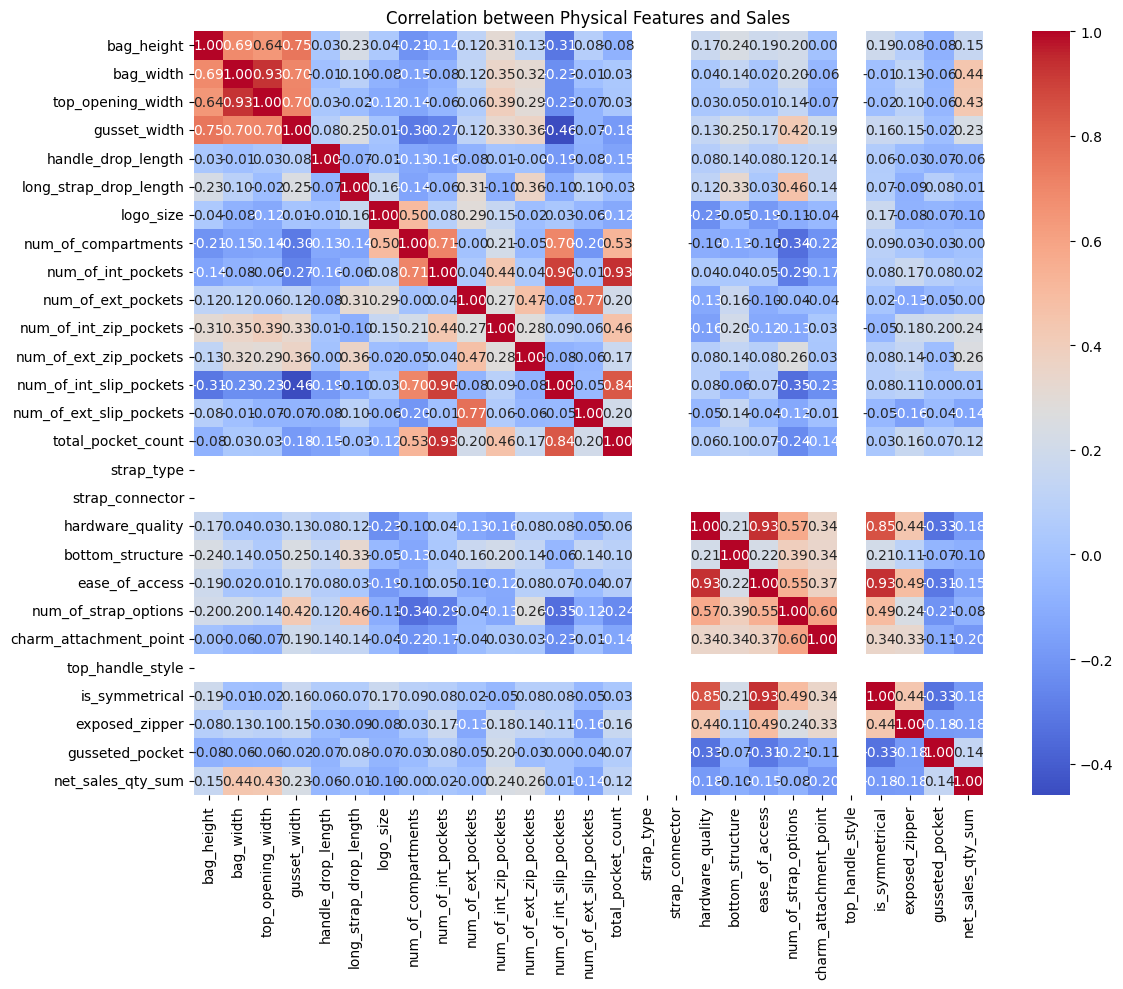

In [105]:
# Select key physical features

physical_features = [
    'bag_height', 'bag_width', 'top_opening_width', 'gusset_width', 
    'handle_drop_length', 'long_strap_drop_length', 'logo_size', 
    'num_of_compartments', 'num_of_int_pockets', 'num_of_ext_pockets', 
    'num_of_int_zip_pockets', 'num_of_ext_zip_pockets', 'num_of_int_slip_pockets', 
    'num_of_ext_slip_pockets', 'total_pocket_count', 'strap_type', 
    'strap_connector', 'hardware_quality', 'bottom_structure', 
    'luggage_sleeve', 'water_bottle_pocket', 'ease_of_access', 
    'num_of_strap_options', 'dust_bag_included', 'key_leash', 
    'charm_attachment_point', 'top_handle_style', 'is_symmetrical', 
    'twist_lock', 'exposed_zipper', 'gusseted_pocket', 'collapsible_gusset'
]


physical_features = [x for x in physical_features if x in df.columns]
# Clean up physical features (convert to numeric if needed)
for col in physical_features:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate correlation with sales metrics
correlation_matrix = df[physical_features + ["net_sales_qty_sum"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Physical Features and Sales')
plt.tight_layout()
plt.show()

D:\Users\gkharad\AppData\Local\Temp\ipykernel_8256\1955204708.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="viridis")


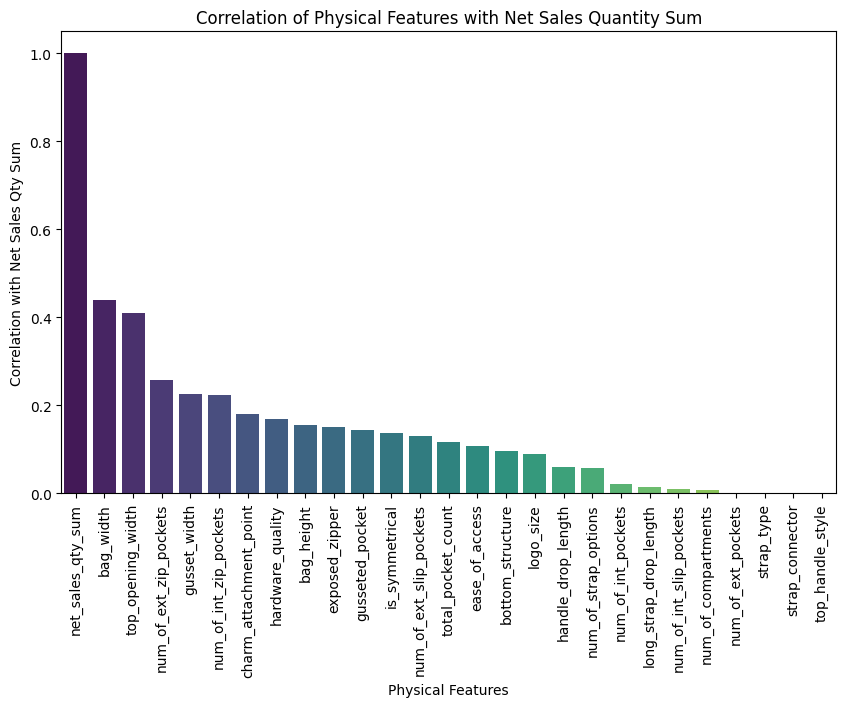

In [73]:

# Calculate the correlation with 'net_sales_qty_sum'
correlation = df[physical_features + ['net_sales_qty_sum']].corr()['net_sales_qty_sum']

# Sort the correlations in absolute order to visualize most significant ones
correlation_sorted = correlation.abs().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Correlation of Physical Features with Net Sales Quantity Sum')
plt.xlabel('Physical Features')
plt.ylabel('Correlation with Net Sales Qty Sum')
plt.show()

D:\Users\gkharad\AppData\Local\Temp\ipykernel_8256\1822153000.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="viridis")


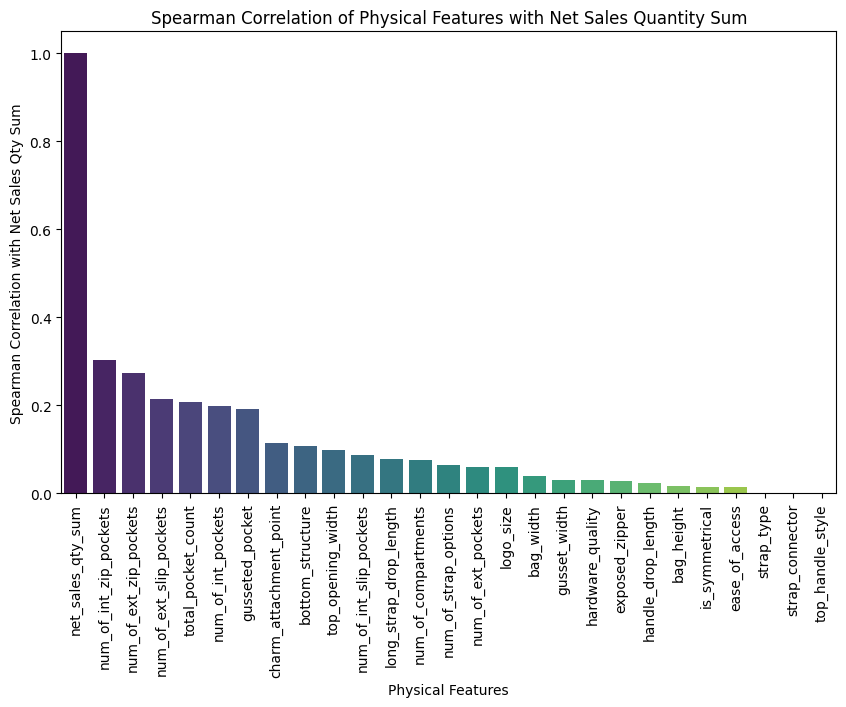

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the Spearman correlation with 'net_sales_qty_sum'
correlation = df[physical_features + ['net_sales_qty_sum']].corr(method='spearman')['net_sales_qty_sum']

# Sort the correlations in absolute order to visualize the most significant ones
correlation_sorted = correlation.abs().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Spearman Correlation of Physical Features with Net Sales Quantity Sum')
plt.xlabel('Physical Features')
plt.ylabel('Spearman Correlation with Net Sales Qty Sum')
plt.show()


### Categorical Feature Analysis


In [107]:
# Analyze categorical features
cat_features = ['material_type_x', 'opener_design', 'opener_material', 
                'leather_texture', 'hardware_color', 'closure_type', 
                'logo_visibility', 'silhouette_type', 'bag_shape', 
                'color', 'interior_lining', 'strap_type', 'strap_connector', 
                'edge_finishing', 'embellishment', 'convertibility', 
                'limited_edition', 'signature_pattern', 'colorblock_design', 
                'quilted_pattern', 'water_resistance', 'corner_protection', 
                'bottom_feet', 'hangtag_presence', 'chain_detail', 
                'turnlock_hardware', 'removable_strap', 'adjustable_strap', 
                'crossbody_option', 'shoulder_option', 'hand_carry_option', 
                'backpack_option', 'wristlet_option', 'wallet_function', 
                'phone_compatibility', 'tablet_compatibility', 
                'luggage_sleeve', 'novelty_shape', 'built_in_mirror', 
                'eco_friendly_material', 'dust_bag_included', 'monogram_option', 
                'key_leash', 'snap_button_closure', 'charm_attachment_point', 
                'hidden_pocket', 'logo_placement', 'logo_style', 'logo_type', 
                'is_symmetrical', 'twist_lock', 'exposed_zipper', 'bow_element', 
                'is_slouchy', 'gusseted_pocket', 'finish_type', 'print_pattern', 
                'floral_elements', 'animal_print', 'stripe_pattern', 
                'woven_elements', 'pearl_elements', 'grommet_count', 
                'pleat_count', 'kisslock_frame', 'collapsible_gusset', 
                'style_code', 'department_desc', 'gender', 'article_cat_ind', 
                'class', 'subclass', 'collection', 'subcollection', 'licensed', 
                'material', 'material_type_y', 'collaboration', 'silhouette', 
                'style_group', 'active', 'size_code', 'color_count', 
                'article_type', 'factory_store_type', 'brandcode']

# df['strap_type'] = df['strap_type'].replace(['Chain with Leather', 'Chain with leather'], 'Leather with Chain')
# df['strap_type'] = df['strap_type'].str.lower()

cat_features = [x for x in cat_features if x in df.columns]
cat_features

['material_type_x',
 'opener_design',
 'opener_material',
 'leather_texture',
 'hardware_color',
 'closure_type',
 'logo_visibility',
 'silhouette_type',
 'bag_shape',
 'color',
 'interior_lining',
 'strap_type',
 'strap_connector',
 'edge_finishing',
 'embellishment',
 'convertibility',
 'signature_pattern',
 'water_resistance',
 'corner_protection',
 'bottom_feet',
 'hangtag_presence',
 'chain_detail',
 'turnlock_hardware',
 'removable_strap',
 'adjustable_strap',
 'crossbody_option',
 'shoulder_option',
 'hand_carry_option',
 'backpack_option',
 'wristlet_option',
 'wallet_function',
 'phone_compatibility',
 'tablet_compatibility',
 'novelty_shape',
 'eco_friendly_material',
 'snap_button_closure',
 'charm_attachment_point',
 'hidden_pocket',
 'logo_placement',
 'logo_style',
 'logo_type',
 'is_symmetrical',
 'exposed_zipper',
 'is_slouchy',
 'gusseted_pocket',
 'finish_type',
 'print_pattern',
 'grommet_count',
 'style_code',
 'department_desc',
 'class',
 'subclass',
 'collection'

feature : logo_visibility
feature : num_of_int_zip_pockets
feature : num_of_ext_pockets
feature : num_of_ext_zip_pockets
feature : num_of_ext_slip_pockets
feature : hardware_quality
feature : bottom_structure
feature : convertibility
feature : signature_pattern
feature : water_resistance
feature : corner_protection
feature : bottom_feet
feature : hangtag_presence
feature : chain_detail
feature : turnlock_hardware
feature : removable_strap
feature : adjustable_strap
feature : laptop_compatibility
feature : crossbody_option
feature : shoulder_option
feature : hand_carry_option
feature : backpack_option
feature : wristlet_option
feature : wallet_function
feature : phone_compatibility
feature : tablet_compatibility
feature : ease_of_access
feature : novelty_shape
feature : eco_friendly_material
feature : snap_button_closure
feature : charm_attachment_point
feature : hidden_pocket
feature : is_symmetrical
feature : exposed_zipper
feature : is_slouchy
feature : gusseted_pocket
feature : prin

D:\Users\gkharad\AppData\Local\Temp\ipykernel_8256\1108683462.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="coolwarm")


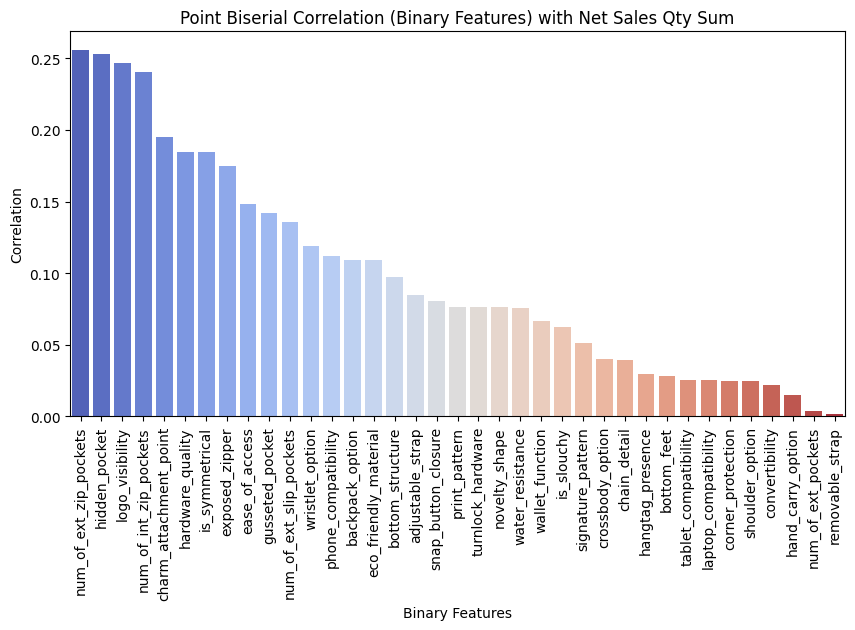

In [113]:
from scipy.stats import pointbiserialr

binary_features = [col for col in df.columns if df[col].nunique() == 2]  # Select binary columns
binary_features.remove("material_type_y")
binary_features.remove("active")

correlations = {}

for feature in binary_features:
    print("feature :",feature)
    corr, _ = pointbiserialr(df[feature], df['net_sales_qty_sum'])
    correlations[feature] = abs(corr)  # Absolute correlation

# Convert to Series and sort
correlation_sorted = pd.Series(correlations).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Point Biserial Correlation (Binary Features) with Net Sales Qty Sum')
plt.xlabel('Binary Features')
plt.ylabel('Correlation')
plt.show()


D:\Users\gkharad\AppData\Local\Temp\ipykernel_8256\1013970292.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="coolwarm")


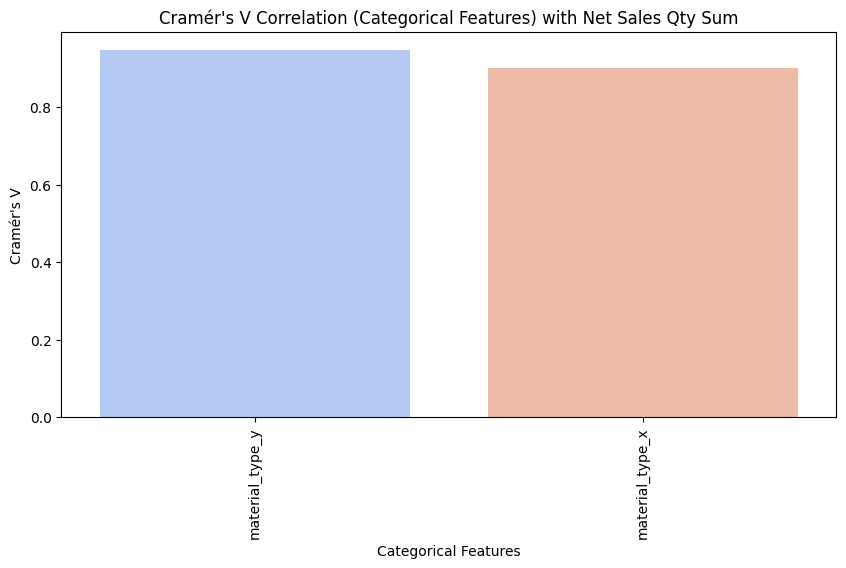

In [114]:
import numpy as np
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

categorical_features = ['material_type_x', 'material_type_y']  # Replace with actual categorical features
correlations = {feature: cramers_v(df[feature], df['net_sales_qty_sum']) for feature in categorical_features}

# Convert to Series and sort
correlation_sorted = pd.Series(correlations).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_sorted.index, y=correlation_sorted.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Cramér's V Correlation (Categorical Features) with Net Sales Qty Sum")
plt.xlabel('Categorical Features')
plt.ylabel("Cramér's V")
plt.show()


In [98]:
# Function to analyze high and low sales for each categorical feature
def analyze_high_low_sales(feature):
    # Group by feature and calculate mean sales
    grouped = df.groupby(feature)[sales_cols].mean().reset_index()
    grouped = grouped.sort_values('net_sales_qty_sum', ascending=False)
    print("gk :: " ,grouped)
    print("type :: " ,type(grouped))

    # # Find the high and low sale values
    # print("High ", grouped[0])
    # print("Low ", grouped[-1])

    high_sell_value = grouped.iloc[0]
    low_sell_value = grouped.iloc[-1]
    
    # Return feature name, high sale value, and low sale value
    return {
        'feature_name': feature,
        'high_sell_value': high_sell_value[feature],
        'low_sell_value': low_sell_value[feature]
    }

# Initialize an empty list to store results
results = []

# Analyze each categorical feature
for feature in cat_features:
    print("cat_feature :",feature)
    if df[feature].nunique() < 20:  # Only analyze if not too many unique values
        results.append(analyze_high_low_sales(feature))

# Create a DataFrame from the results
high_low_sales_df = pd.DataFrame(results)

# Display the resulting DataFrame
print(high_low_sales_df)

cat_feature : material_type_x


gk ::                                        material_type_x  net_sales_qty_sum  \
0                                      BONDED LEATHER          130467.00   
13                            REFINED PEBBLED LEATHER           50270.00   
15                                     SMOOTH LEATHER           36254.00   
3                                DOUBLE FACED LEATHER           30202.00   
14                                          SIGNATURE           25459.00   
16                                 SPAZZOLATO LEATHER           20619.50   
12                                                  R           16133.00   
6                                             LEATHER            9458.75   
8                                               MIXED            3577.00   
11                                    PEBBLED LEATHER             609.00   
10                                     PEBBLE LEATHER             155.00   
9   MIXED (ASIAN FAILLE, KIMLON, BONDED LEATHER, N...              91.00   
1    

IndexError: single positional indexer is out-of-bounds

In [115]:
import pandas as pd

# Function to analyze high and low sales for each categorical feature
def analyze_high_low_sales(feature):
    # Group by feature and calculate mean sales, then sort in descending order
    grouped = df.groupby(feature)[sales_cols].mean().reset_index()
    grouped = grouped.sort_values('net_sales_qty_sum', ascending=False)

    # Check if grouped DataFrame is empty
    if grouped.empty:
        return None  # Skip this feature if no data is available

    # Pick the first row as high sell value and the last row as low sell value
    high_sell_value = grouped.iloc[0]  # First row (highest value)
    low_sell_value = grouped.iloc[-1]  # Last row (lowest value)

    # Return feature name, high sell value, and low sell value
    return {
        'feature_name': feature,
        'high_sell_value': high_sell_value[feature],
        'low_sell_value': low_sell_value[feature]
    }

# Initialize an empty list to store results
results = []

# Analyze each categorical feature
for feature in cat_features:
    if df[feature].nunique() < 20:  # Only analyze if not too many unique values
        result = analyze_high_low_sales(feature)
        if result:  # Only add non-empty results
            results.append(result)

# Create a DataFrame from the results
high_low_sales_df = pd.DataFrame(results)

# Display the resulting DataFrame
print(high_low_sales_df)

high_low_sales_df.to_excel("high_low_sales_df.xlsx")


              feature_name high_sell_value                   low_sell_value
0          material_type_x  BONDED LEATHER               CROSSGRAIN LEATHER
1            opener_design            FLAP               FLAP WITH TURNLOCK
2          opener_material         LEATHER                            METAL
3          leather_texture            SOFT                       CROSSGRAIN
4           hardware_color           MIXED                           SILVER
5             closure_type          BUCKLE  MAGNET CLOSURE WITH BRIDGE/SNAP
6          logo_visibility             0.0                              1.0
7                bag_shape            BOXY                             DOME
8                    color   NOT SPECIFIED                     CHERRY PRINT
9          interior_lining            ACE1                              MP2
10          edge_finishing      3MM PIPING                          BINDING
11           embellishment    BLIND EMBOSS                            BOMBE
12          


Top 5 material_type_x categories by sales:


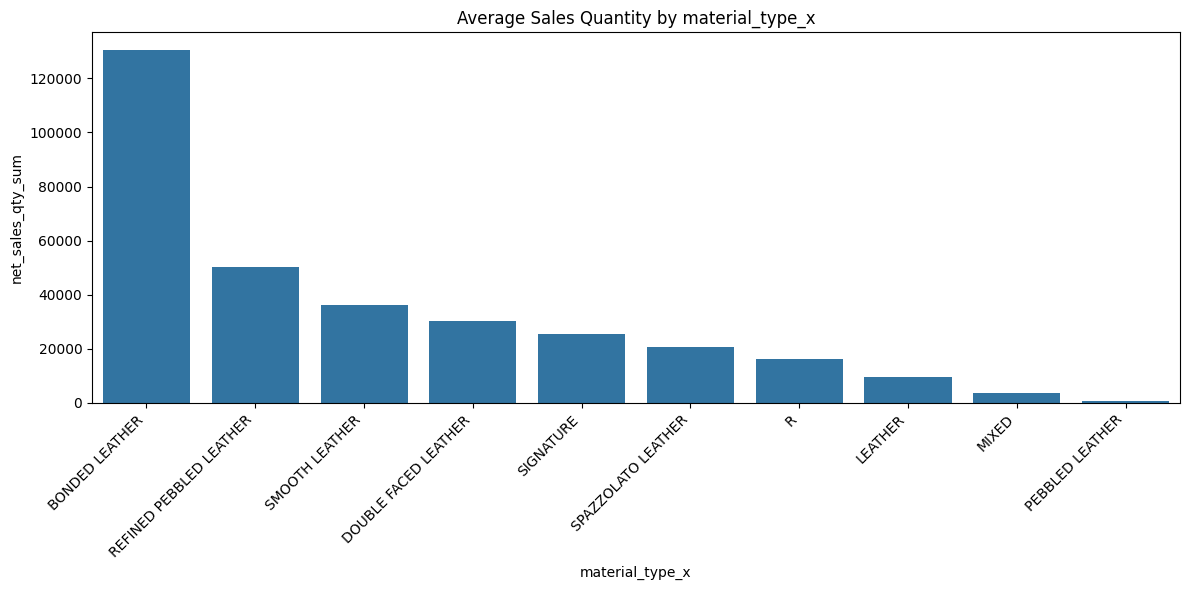

            material_type_x  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0            BONDED LEATHER           130467.0            14632120.64   
12  REFINED PEBBLED LEATHER            50270.0             6074892.34   
14           SMOOTH LEATHER            36254.0             5253843.02   
3      DOUBLE FACED LEATHER            30202.0             5761756.18   
13                SIGNATURE            25459.0             2532366.58   

    max_qty_sold_at_store  
0                 94816.0  
12                16908.0  
14                13234.0  
3                 15607.0  
13                17679.0  

Top 5 opener_design categories by sales:


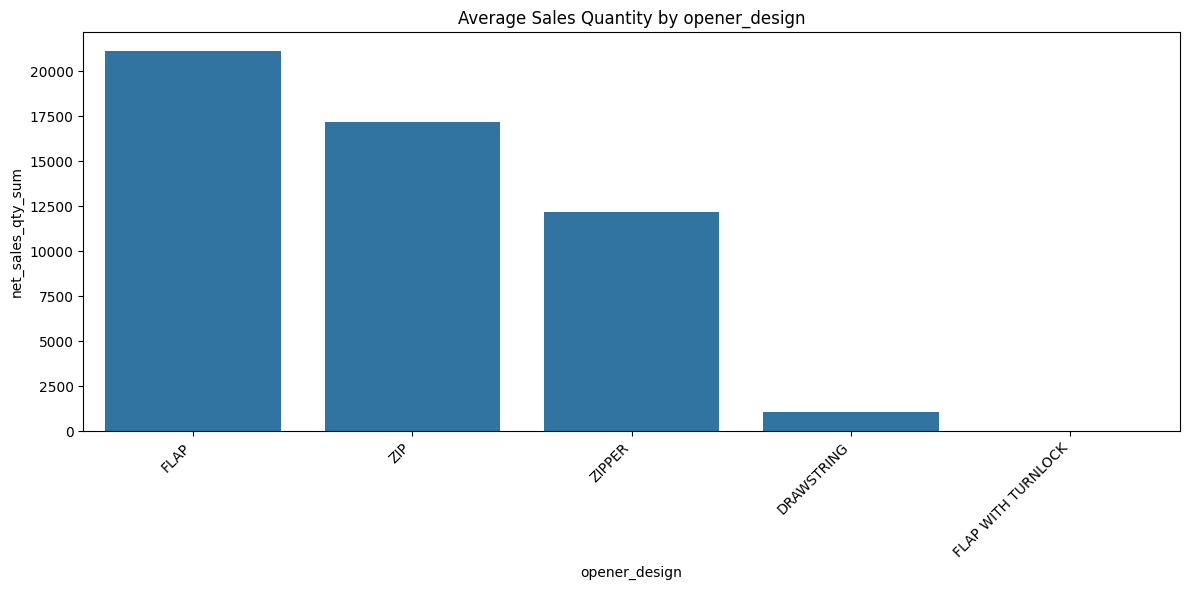

        opener_design  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                FLAP       21120.000000           2.615366e+06   
3                 ZIP       17193.000000           1.437483e+06   
4              ZIPPER       12207.928571           1.588240e+06   
0          DRAWSTRING        1093.000000           1.379457e+05   
2  FLAP WITH TURNLOCK           0.000000           0.000000e+00   

   max_qty_sold_at_store  
1            8808.777778  
3            5589.000000  
4            6669.571429  
0            1018.000000  
2               0.000000  

Top 5 opener_material categories by sales:


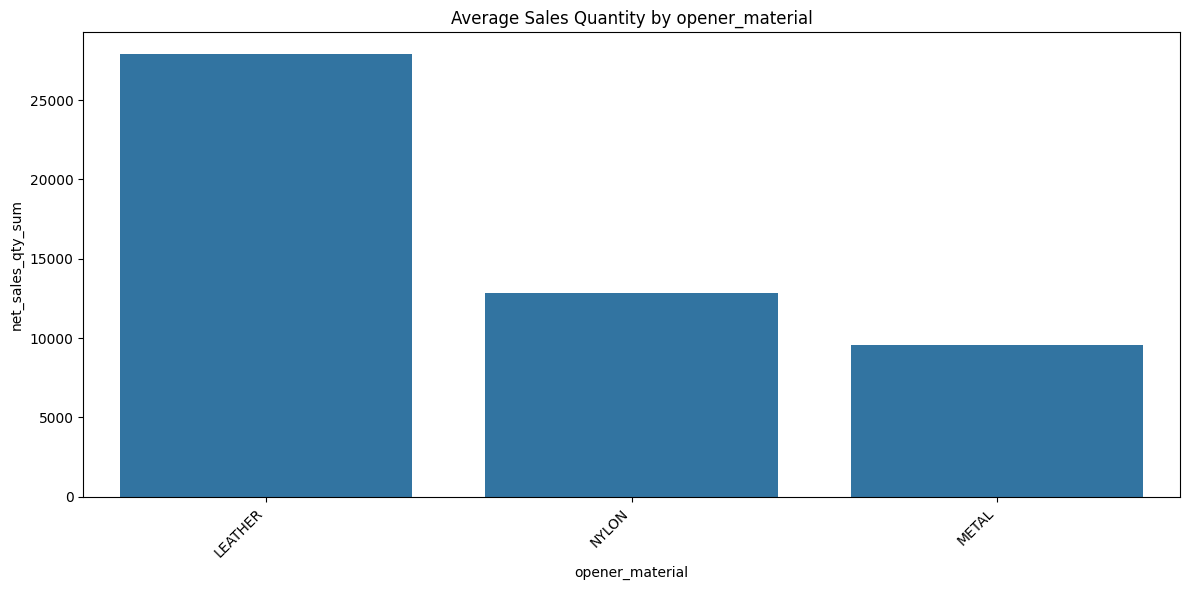

  opener_material  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0         LEATHER       27872.727273           3.326086e+06   
2           NYLON       12829.500000           1.274827e+06   
1           METAL        9558.054054           1.310159e+06   

   max_qty_sold_at_store  
0           15296.181818  
2            8869.000000  
1            4075.486486  

Top 5 leather_texture categories by sales:


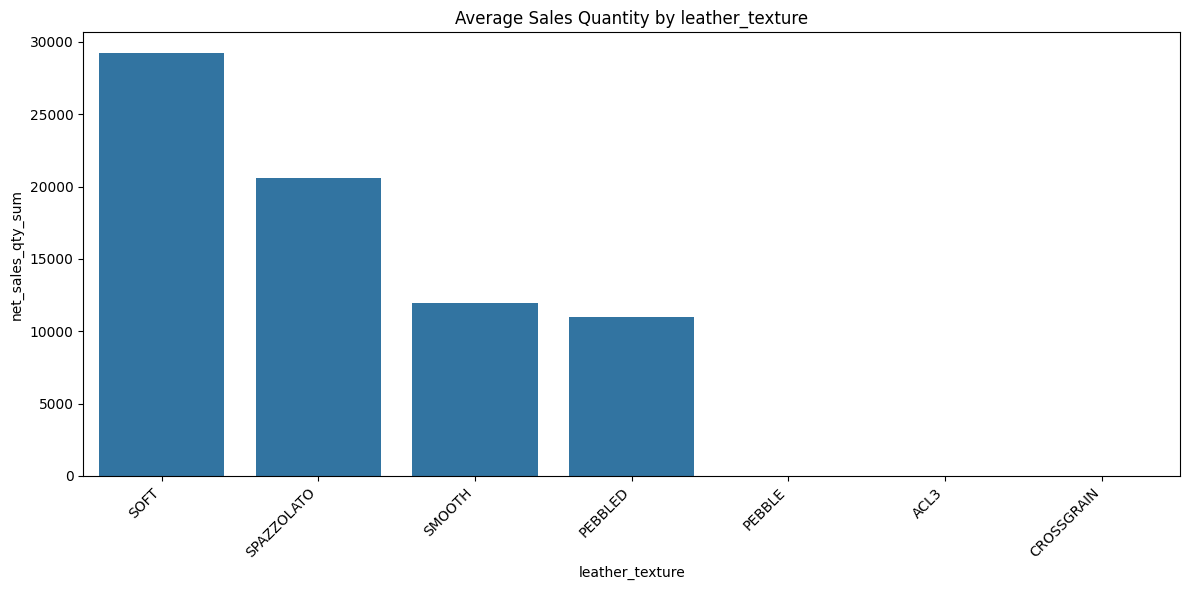

  leather_texture  net_sales_qty_sum  net_sales_amt_lcl_sum  \
5            SOFT       29195.000000           4.330835e+06   
6      SPAZZOLATO       20619.500000           3.585317e+06   
4          SMOOTH       11979.272727           1.197698e+06   
3         PEBBLED       10988.760000           1.587009e+06   
2          PEBBLE           0.000000           2.212000e+01   

   max_qty_sold_at_store  
5            7334.000000  
6            9792.500000  
4            4826.363636  
3            5151.440000  
2               0.000000  

Top 5 hardware_color categories by sales:


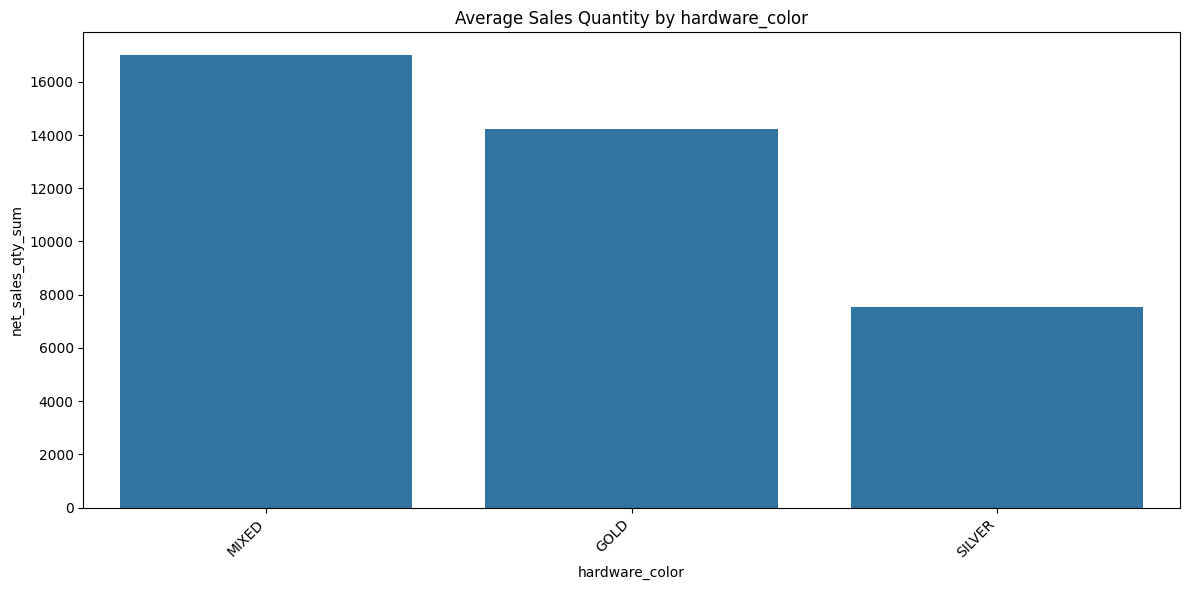

  hardware_color  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1          MIXED       17011.000000           2.547294e+06   
0           GOLD       14219.822222           1.855484e+06   
2         SILVER        7528.000000           5.719665e+05   

   max_qty_sold_at_store  
1            7374.000000  
0            7166.133333  
2            2470.500000  

Top 5 closure_type categories by sales:


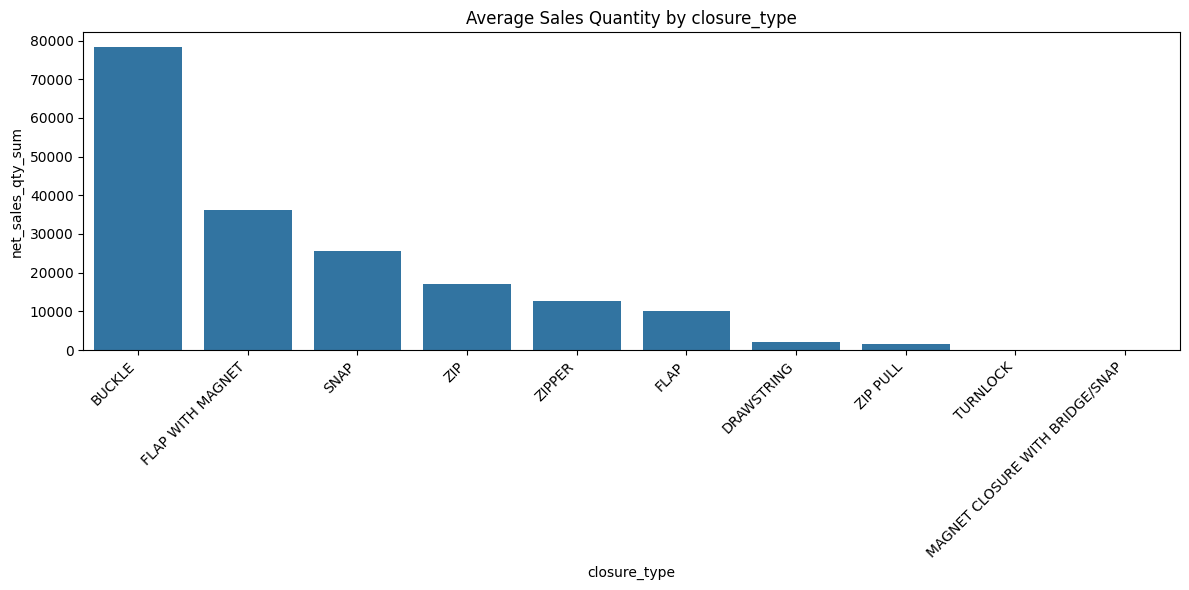

       closure_type  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0            BUCKLE            78207.0           1.162587e+07   
3  FLAP WITH MAGNET            36254.0           5.253843e+06   
5              SNAP            25573.0           1.378759e+06   
7               ZIP            17193.0           1.437483e+06   
9            ZIPPER            12779.2           1.662818e+06   

   max_qty_sold_at_store  
0               31013.00  
3               13234.00  
5               13563.00  
7                5589.00  
9                6972.85  

Top 5 logo_visibility categories by sales:


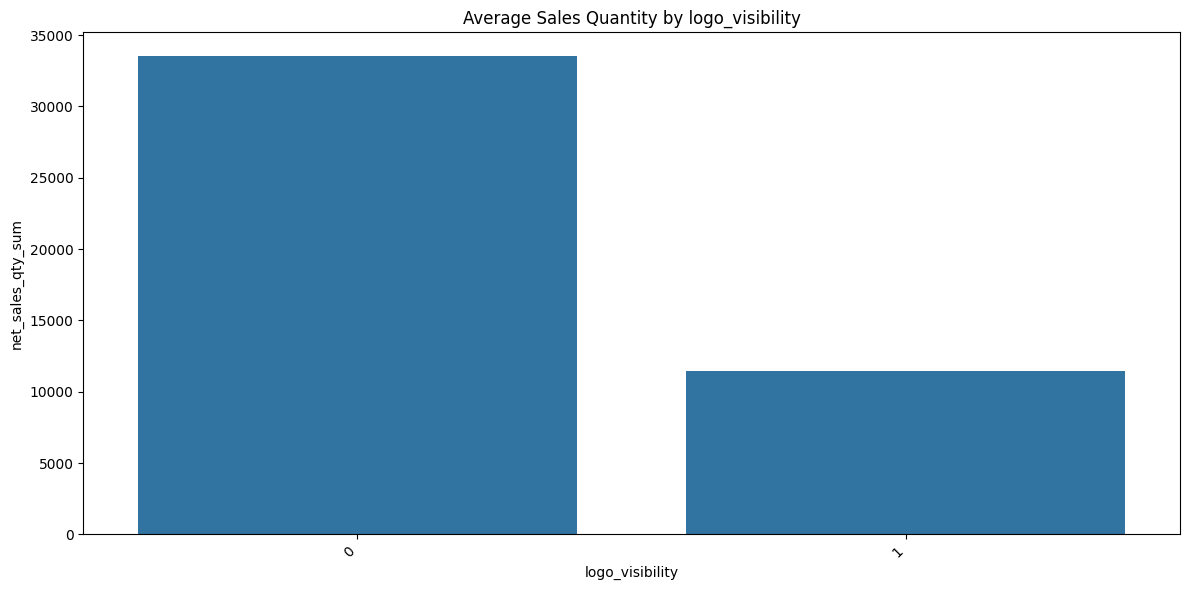

   logo_visibility  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0       33517.000000           3.701985e+06   
1                1       11488.566038           1.486076e+06   

   max_qty_sold_at_store  
0           24012.000000  
1            5241.056604  

Top 5 bag_shape categories by sales:


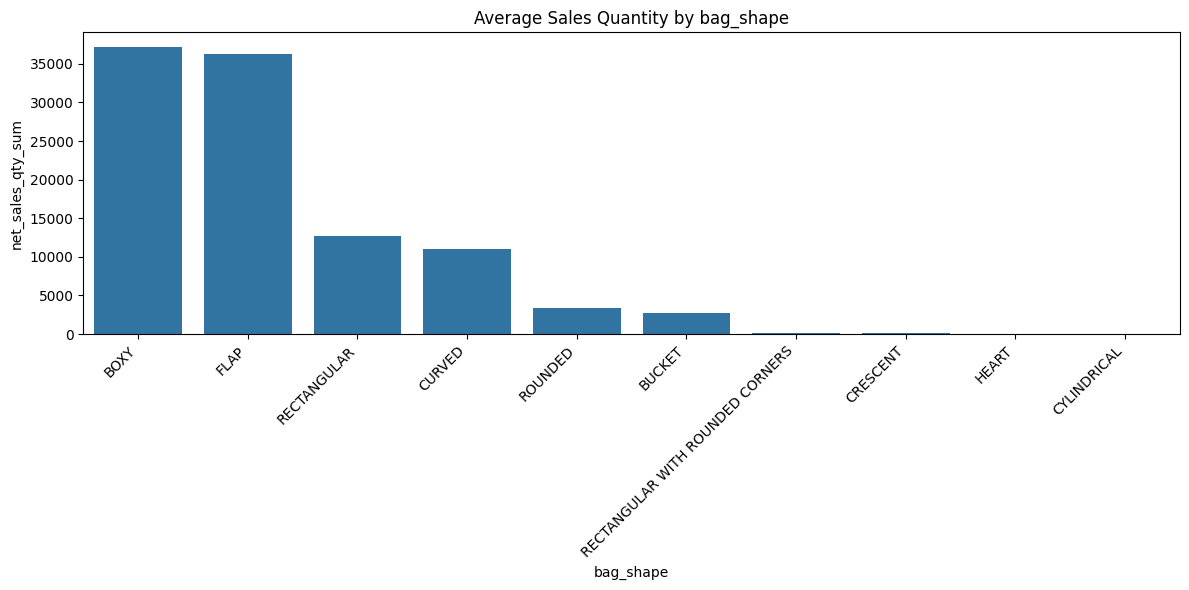

      bag_shape  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0          BOXY       37220.000000           3.916454e+06   
6          FLAP       36254.000000           5.253843e+06   
8   RECTANGULAR       12646.157895           1.595461e+06   
3        CURVED       10970.750000           1.844068e+06   
10      ROUNDED        3365.000000           3.188380e+05   

    max_qty_sold_at_store  
0            27884.000000  
6            13234.000000  
8             5623.394737  
3             4045.250000  
10             966.000000  

Top 5 color categories by sales:


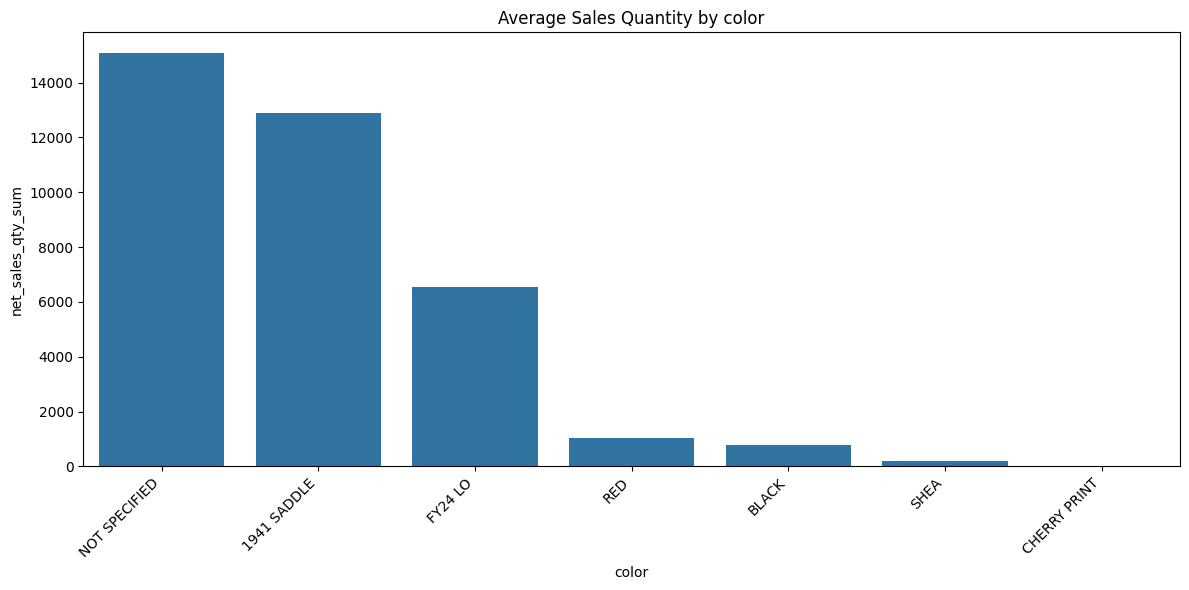

           color  net_sales_qty_sum  net_sales_amt_lcl_sum  \
4  NOT SPECIFIED       15078.300000           1.960497e+06   
0    1941 SADDLE       12895.000000           2.408257e+06   
3        FY24 LO        6526.000000           8.491956e+05   
5            RED        1018.000000           1.090976e+05   
1          BLACK         781.666667           1.034256e+05   

   max_qty_sold_at_store  
4                5751.15  
0                6708.00  
3                4144.00  
5                 232.00  
1                  29.00  

Top 5 interior_lining categories by sales:


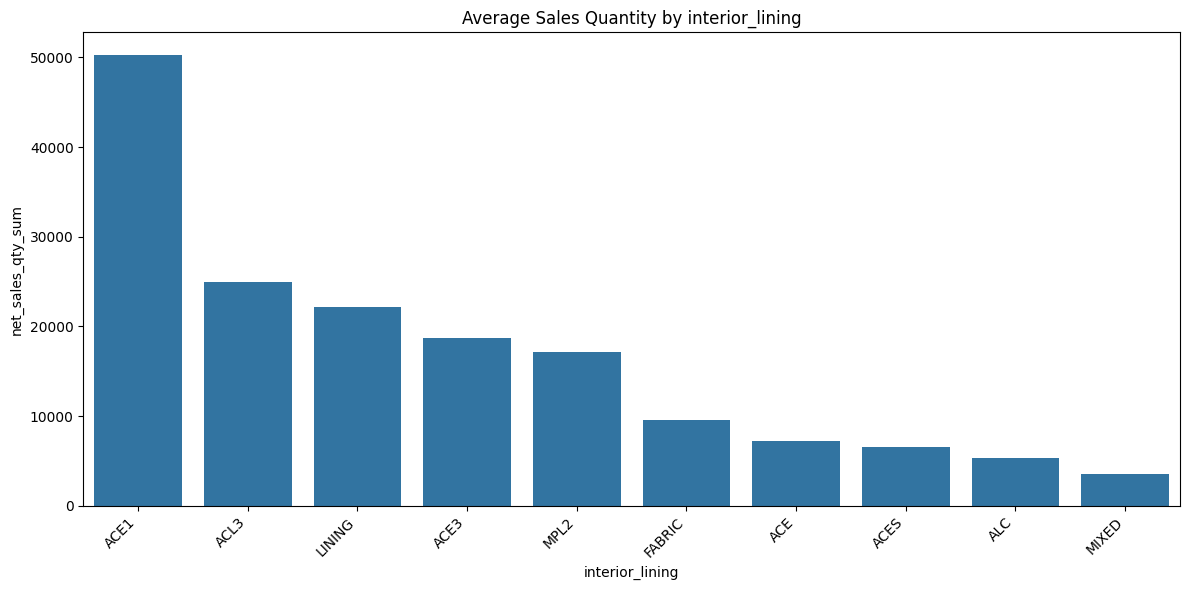

   interior_lining  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1             ACE1            50270.0            6074892.340   
5             ACL3            24932.6            3473594.674   
9           LINING            22173.0            2066596.950   
2             ACE3            18723.5            1978252.455   
13            MPL2            17193.0            1437482.610   

    max_qty_sold_at_store  
1                 16908.0  
5                 12050.2  
9                  9370.0  
2                 13992.5  
13                 5589.0  

Top 5 strap_type categories by sales:


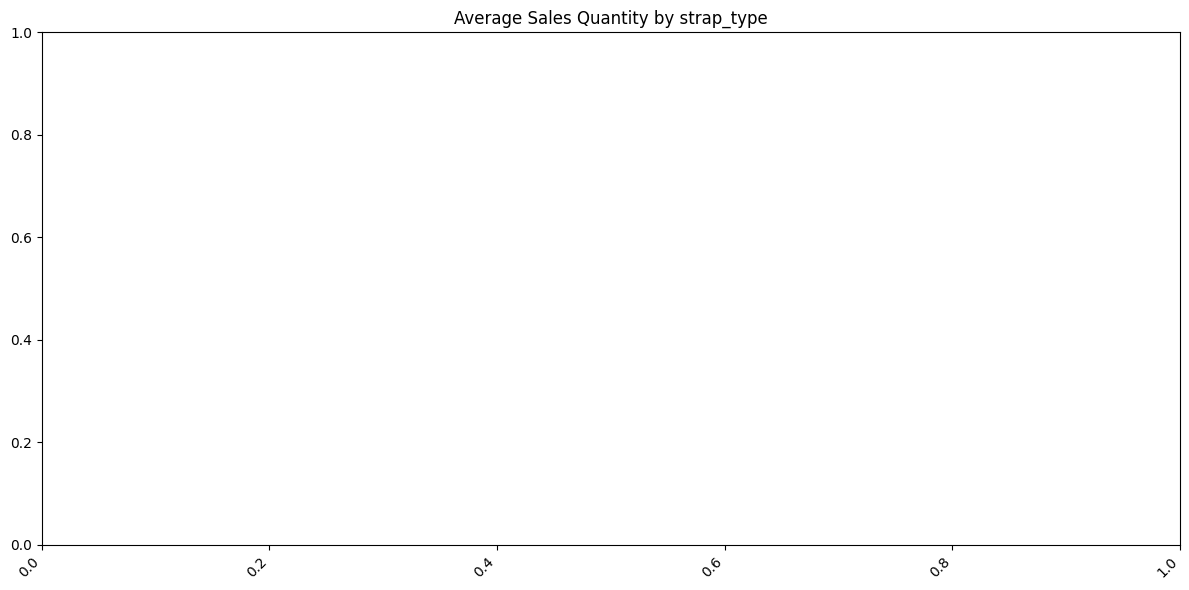

Empty DataFrame
Columns: [strap_type, net_sales_qty_sum, net_sales_amt_lcl_sum, max_qty_sold_at_store]
Index: []

Top 5 strap_connector categories by sales:


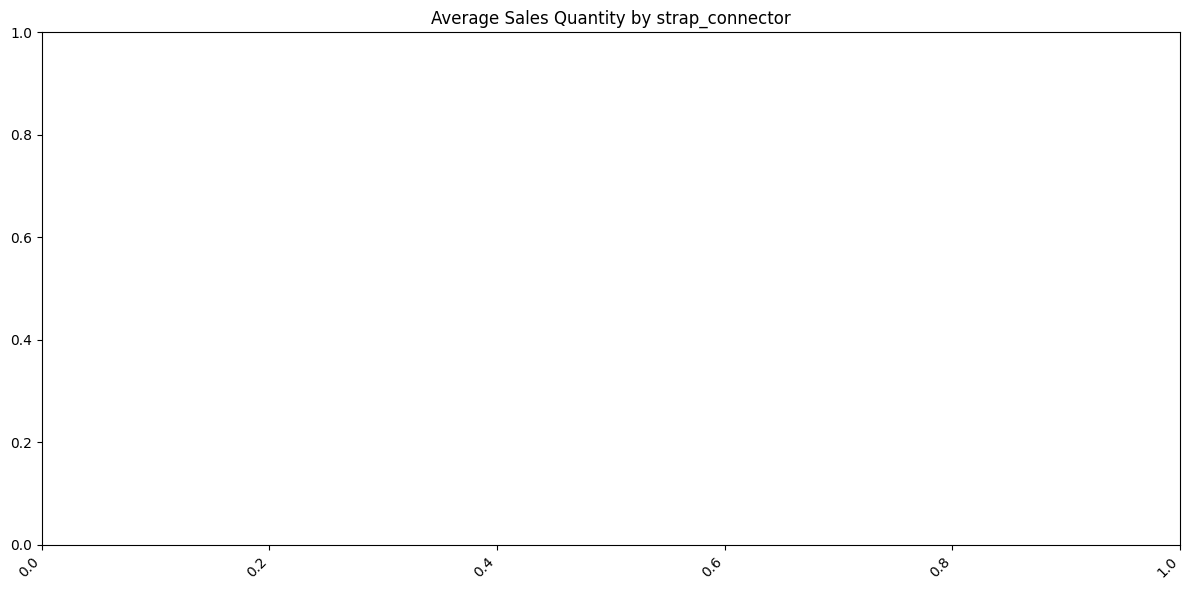

Empty DataFrame
Columns: [strap_connector, net_sales_qty_sum, net_sales_amt_lcl_sum, max_qty_sold_at_store]
Index: []

Top 5 edge_finishing categories by sales:


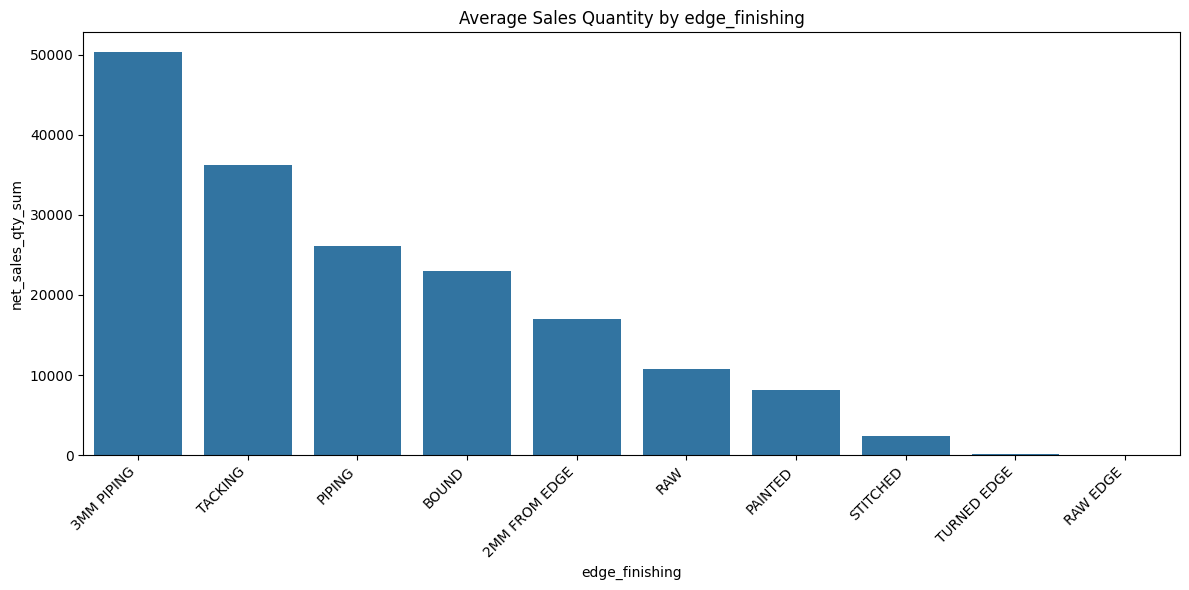

  edge_finishing  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1     3MM PIPING       50270.000000             6074892.34   
9        TACKING       36254.000000             5253843.02   
5         PIPING       26121.666667             3881912.23   
3          BOUND       23014.900000             3154676.60   
0  2MM FROM EDGE       17011.000000             2547294.13   

   max_qty_sold_at_store  
1                16908.0  
9                13234.0  
5                10342.0  
3                14057.0  
0                 7374.0  

Top 5 embellishment categories by sales:


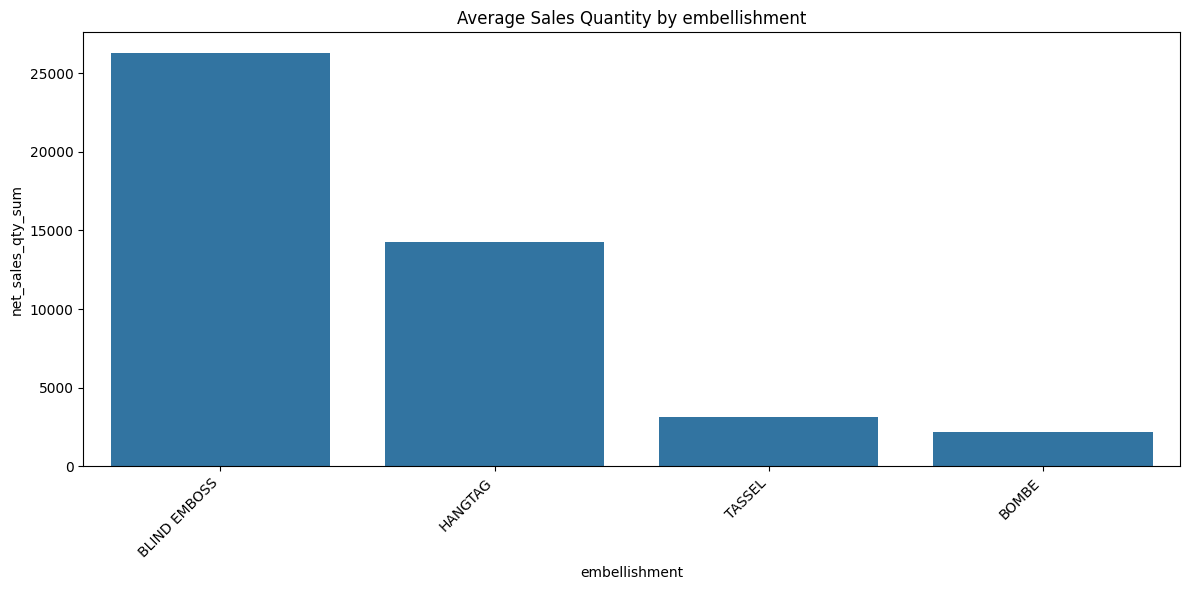

  embellishment  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0  BLIND EMBOSS       26276.000000           3.189204e+06   
2       HANGTAG       14258.681818           1.733317e+06   
3        TASSEL        3124.000000           3.426826e+05   
1         BOMBE        2186.000000           2.758914e+05   

   max_qty_sold_at_store  
0            8840.000000  
2            9042.772727  
3            1013.000000  
1            2036.000000  

Top 5 convertibility categories by sales:


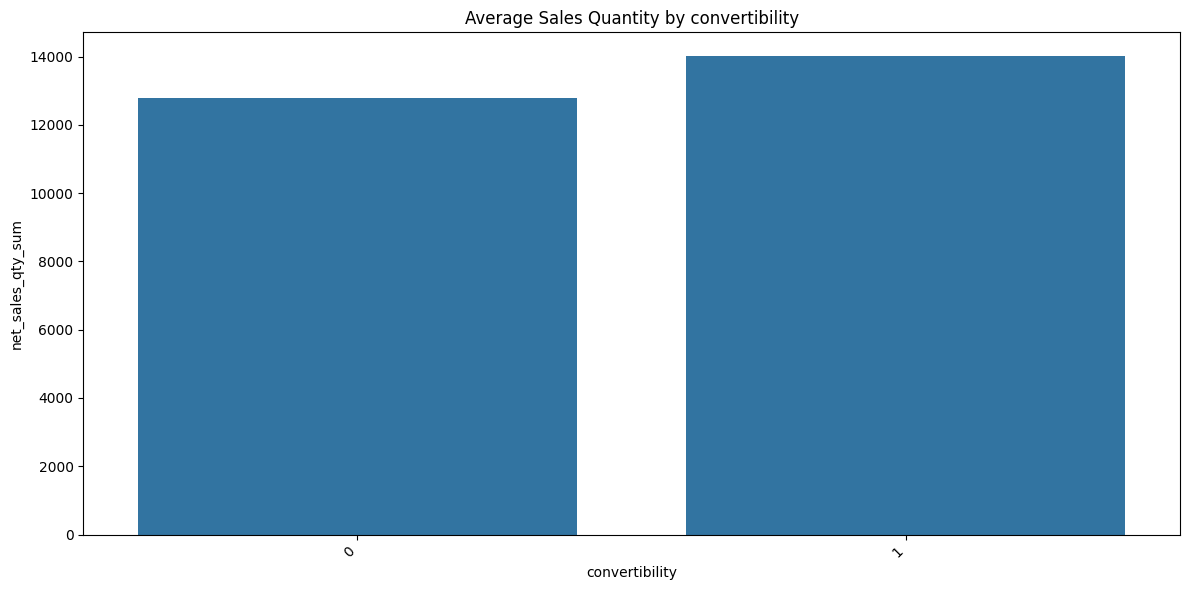

   convertibility  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1               1       14009.333333           1.894709e+06   
0               0       12774.444444           1.574076e+06   

   max_qty_sold_at_store  
1            6755.583333  
0            6505.711111  

Top 5 signature_pattern categories by sales:


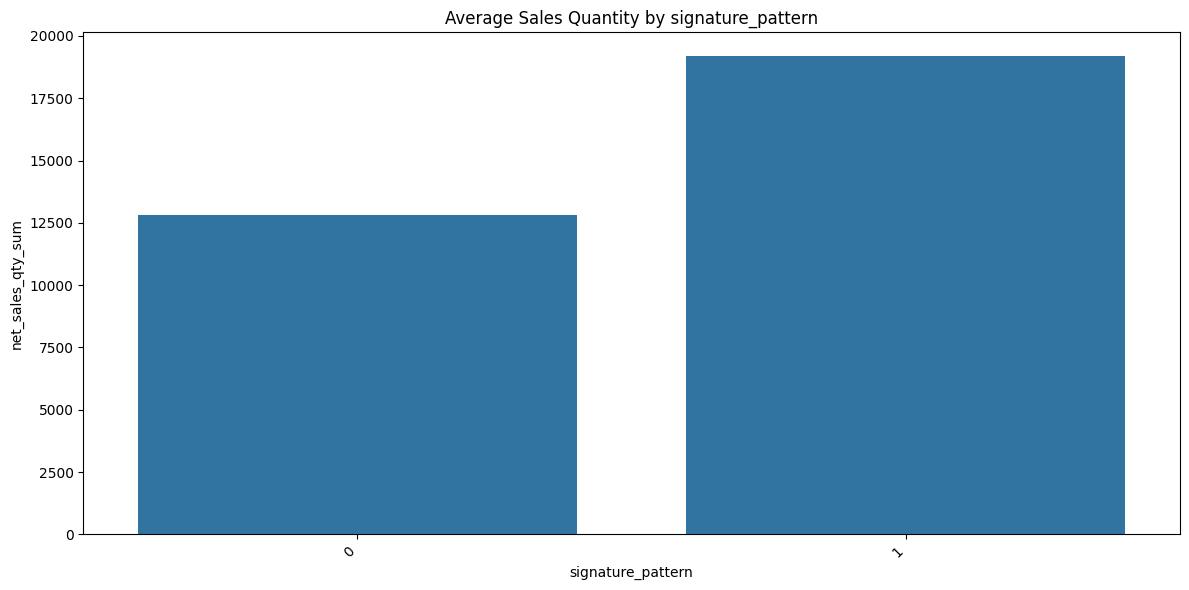

   signature_pattern  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                  1       19184.500000           1.854498e+06   
0                  0       12810.781818           1.633835e+06   

   max_qty_sold_at_store  
1           11059.000000  
0            6394.654545  

Top 5 water_resistance categories by sales:


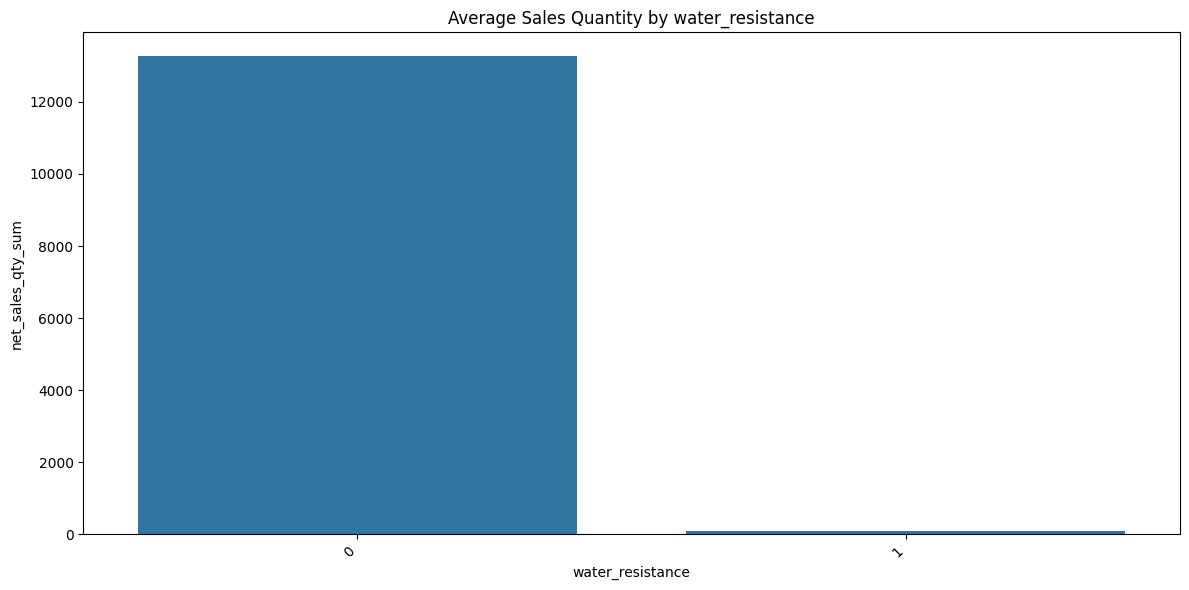

   water_resistance  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                 0       13265.553571           1.670843e+06   
1                 1          91.000000           2.753180e+03   

   max_qty_sold_at_store  
0            6674.446429  
1              55.000000  

Top 5 corner_protection categories by sales:


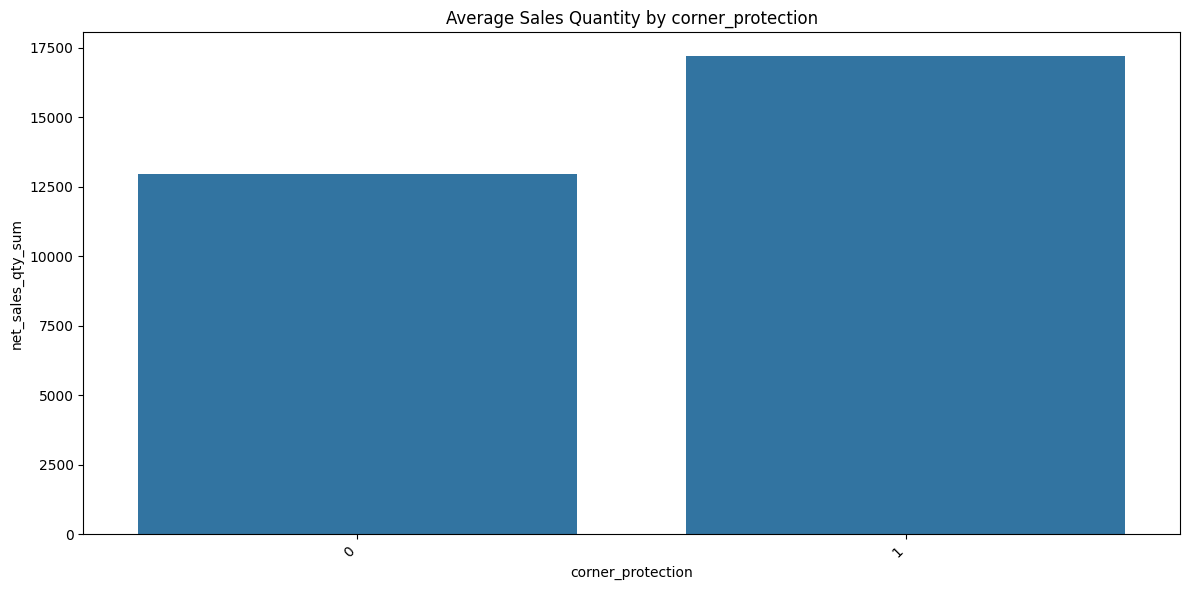

   corner_protection  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                  1       17193.000000           1.437483e+06   
0                  0       12960.160714           1.645223e+06   

   max_qty_sold_at_store  
1               5589.000  
0               6575.625  

Top 5 bottom_feet categories by sales:


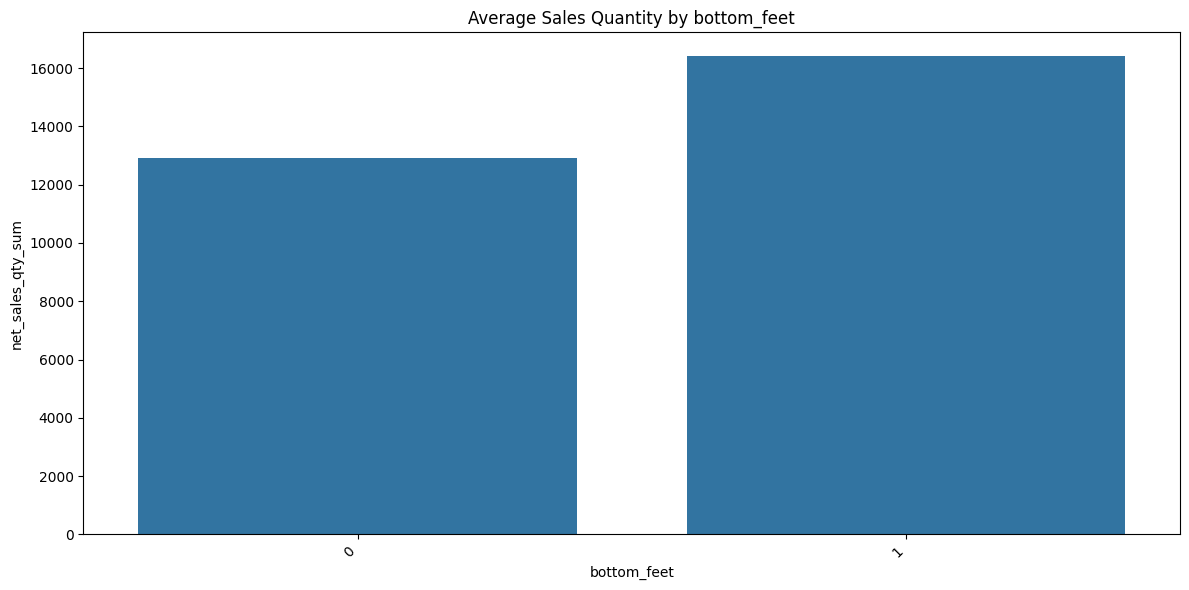

   bottom_feet  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1            1       16405.000000           2.662670e+06   
0            0       12911.854545           1.604447e+06   

   max_qty_sold_at_store  
1            9616.000000  
0            6447.127273  

Top 5 hangtag_presence categories by sales:


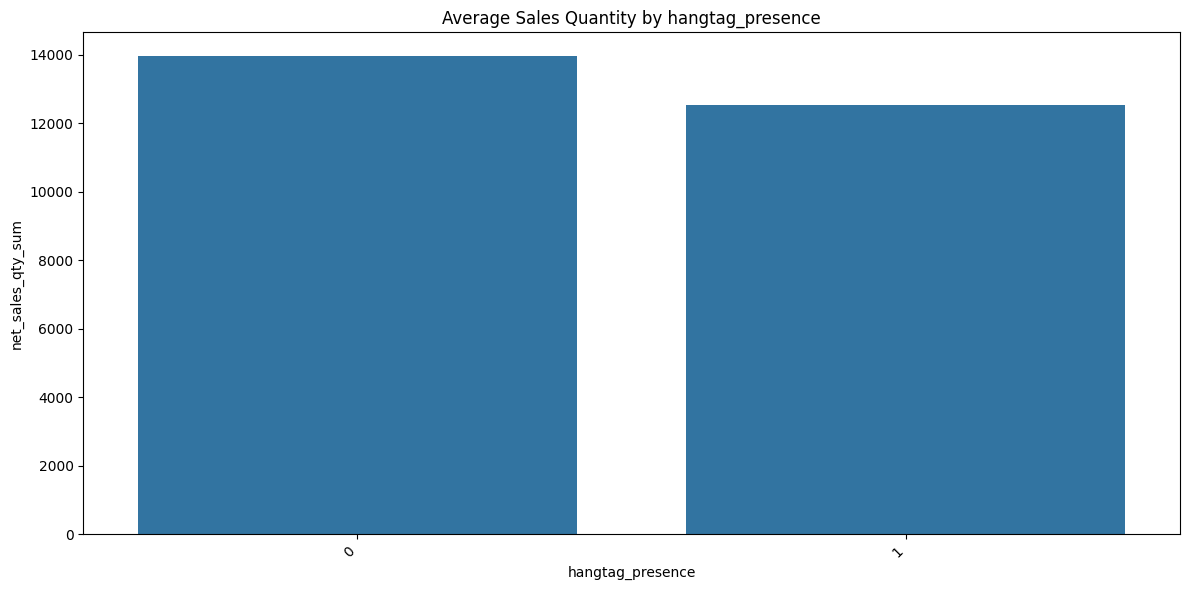

   hangtag_presence  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                 0       13956.100000           1.475858e+06   
1                 1       12536.216216           1.731156e+06   

   max_qty_sold_at_store  
0            8349.150000  
1            5590.297297  

Top 5 chain_detail categories by sales:


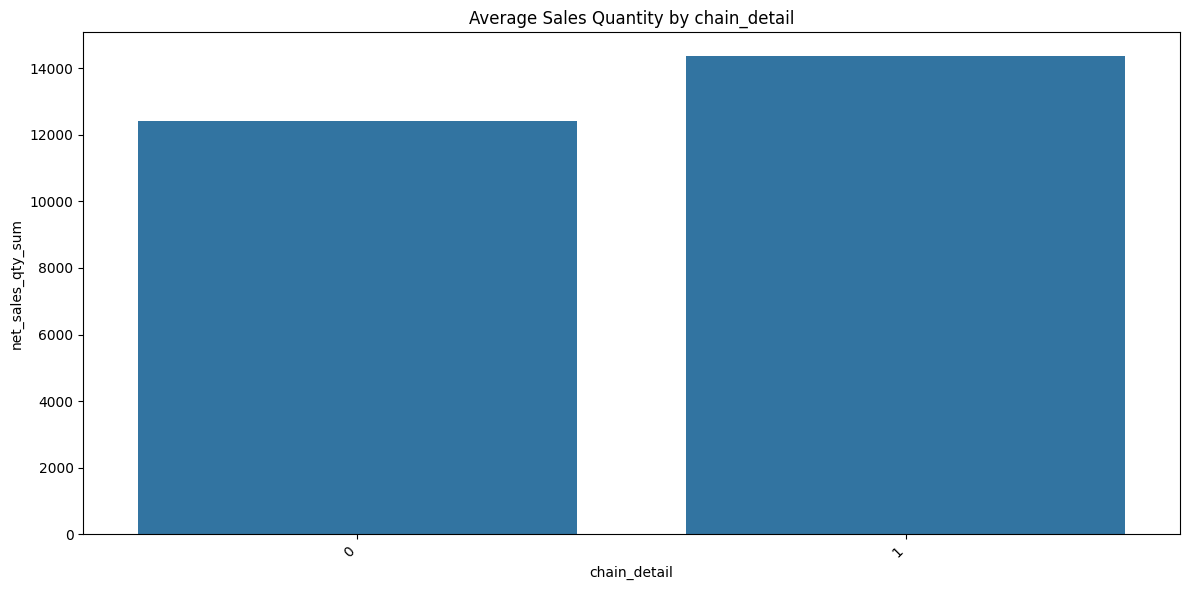

   chain_detail  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1             1       14358.222222           2.111047e+06   
0             0       12423.435897           1.424900e+06   

   max_qty_sold_at_store  
1            6658.555556  
0            6512.051282  

Top 5 turnlock_hardware categories by sales:


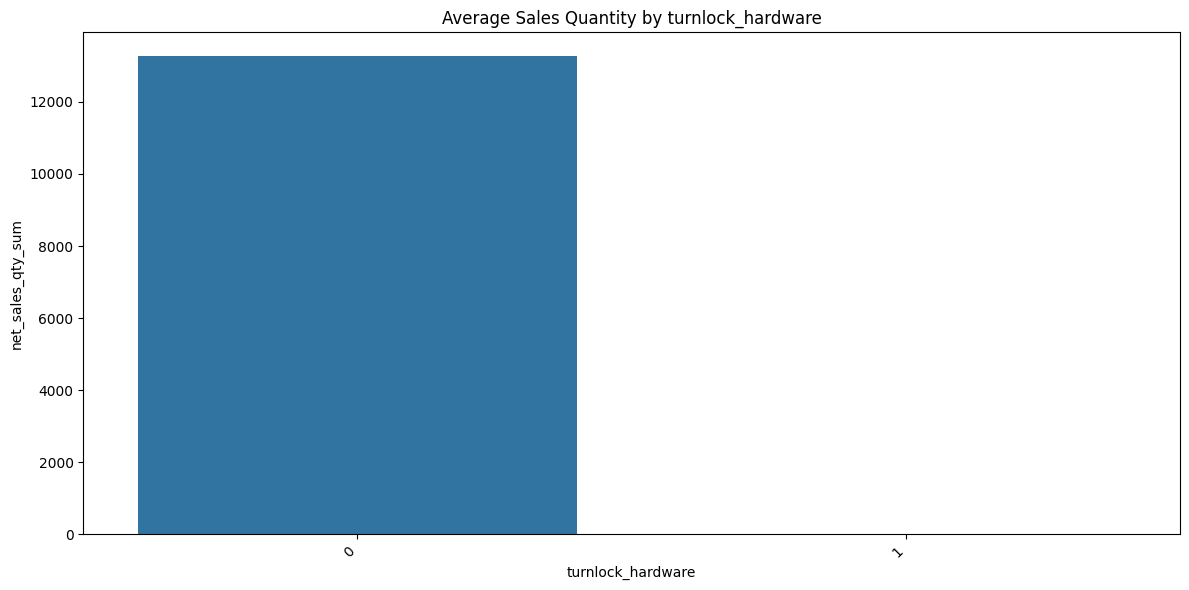

   turnlock_hardware  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                  0       13267.107143           1.670887e+06   
1                  1           4.000000           2.694600e+02   

   max_qty_sold_at_store  
0            6675.410714  
1               1.000000  

Top 5 removable_strap categories by sales:


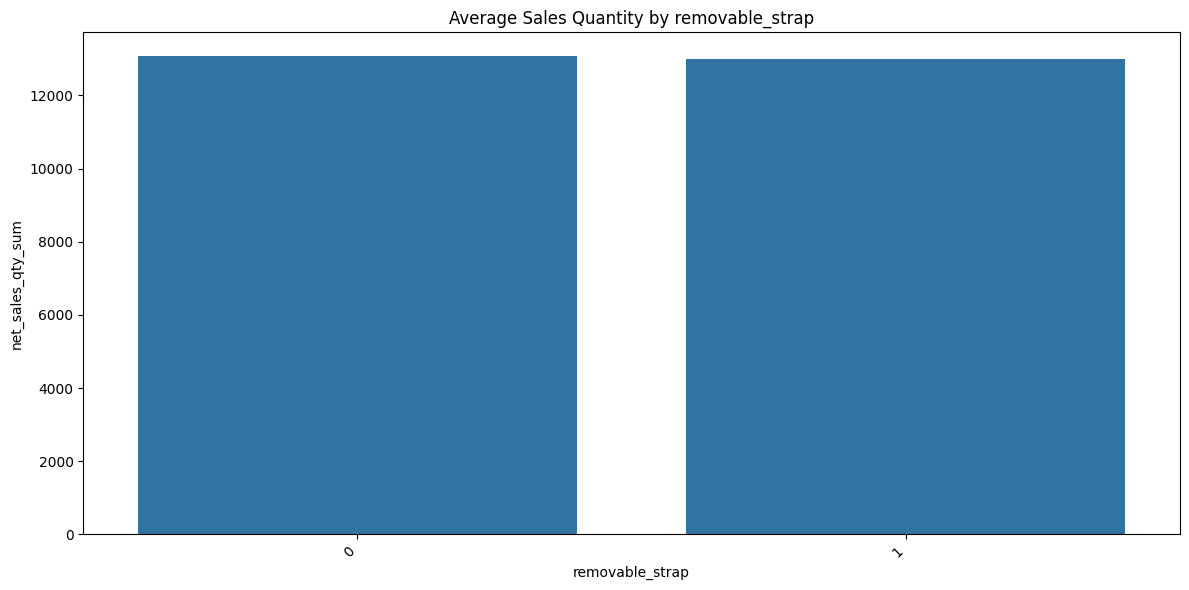

   removable_strap  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0       13069.588235           1.555272e+06   
1                1       12982.434783           1.769160e+06   

   max_qty_sold_at_store  
0            6916.647059  
1            6028.608696  

Top 5 adjustable_strap categories by sales:


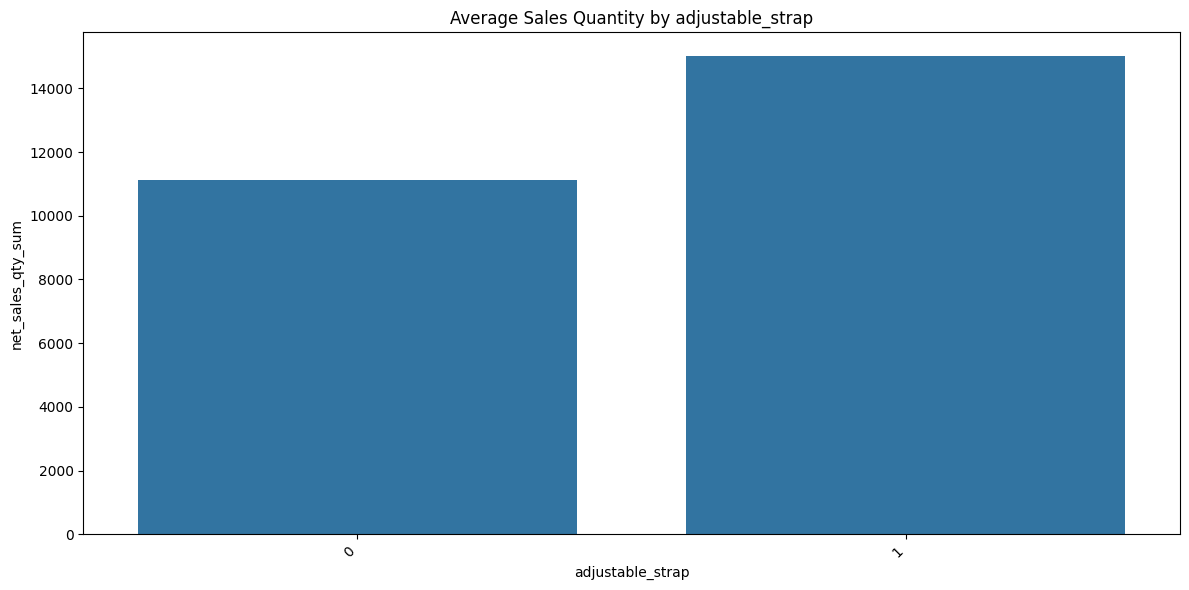

   adjustable_strap  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                 1       15005.250000           2.024957e+06   
0                 0       11131.551724           1.271419e+06   

   max_qty_sold_at_store  
1            6634.464286  
0            6484.793103  

Top 5 crossbody_option categories by sales:


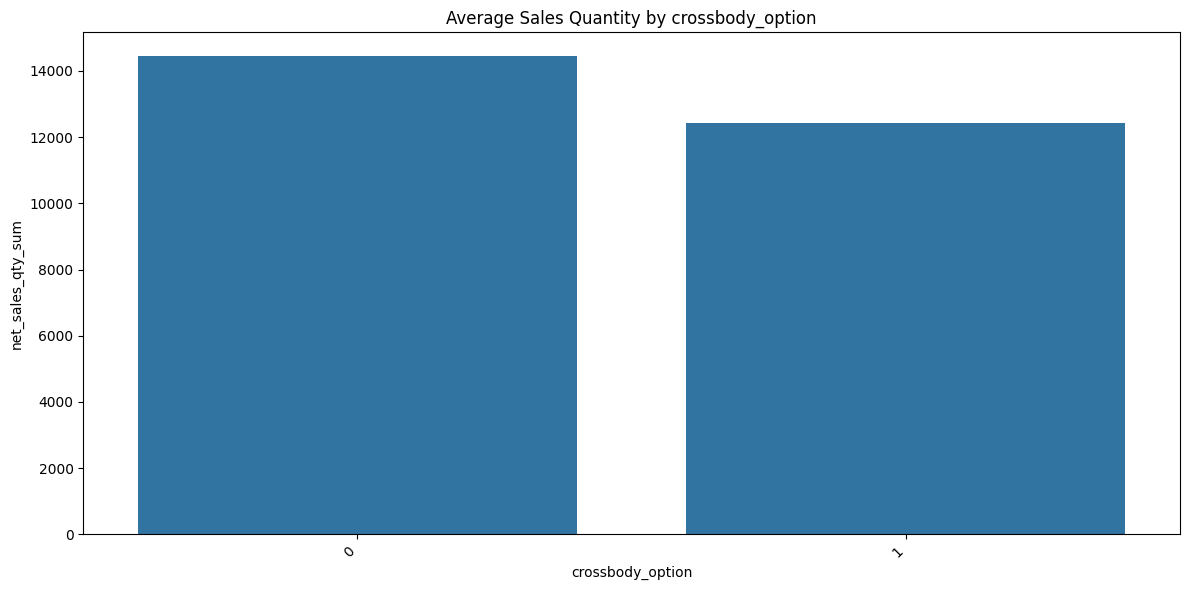

   crossbody_option  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                 0          14443.000           1.477856e+06   
1                 1          12435.775           1.711160e+06   

   max_qty_sold_at_store  
0            9226.647059  
1            5424.275000  

Top 5 shoulder_option categories by sales:


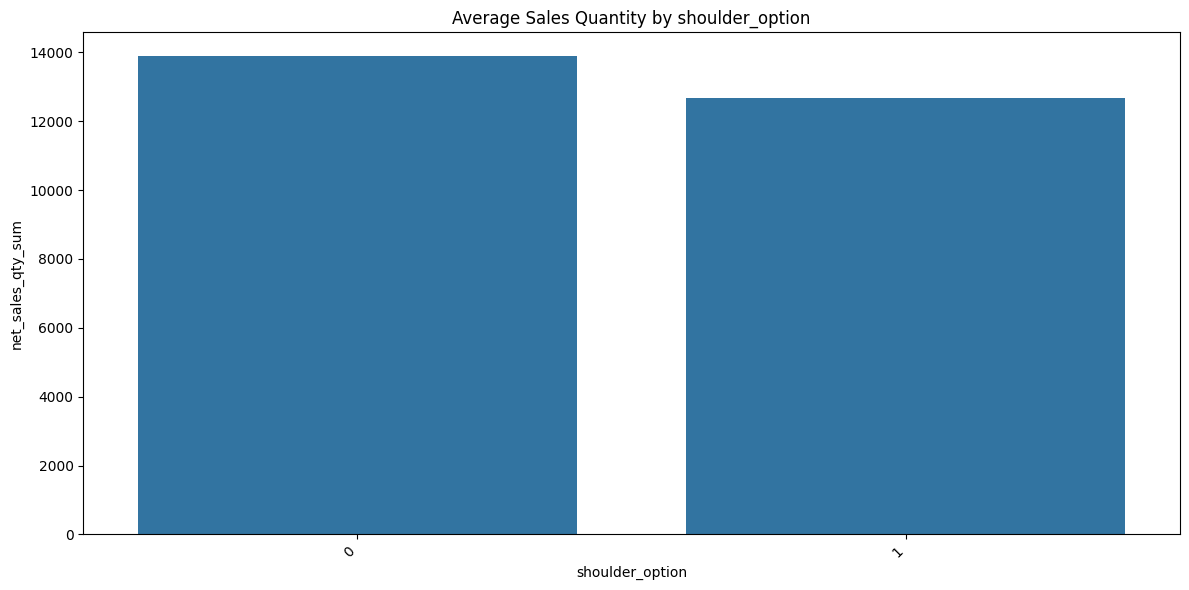

   shoulder_option  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0       13886.117647           1.431659e+06   
1                1       12672.450000           1.730794e+06   

   max_qty_sold_at_store  
0            8685.764706  
1            5654.150000  

Top 5 hand_carry_option categories by sales:


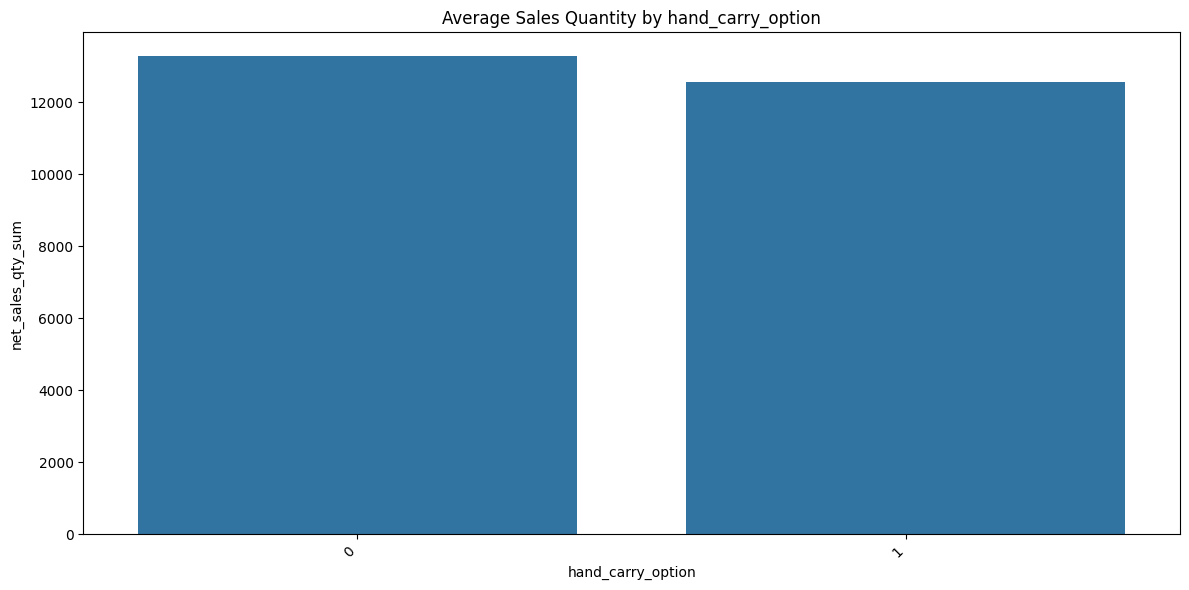

   hand_carry_option  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                  0       13272.973684           1.625853e+06   
1                  1       12557.315789           1.673027e+06   

   max_qty_sold_at_store  
0            6794.052632  
1            6086.842105  

Top 5 backpack_option categories by sales:


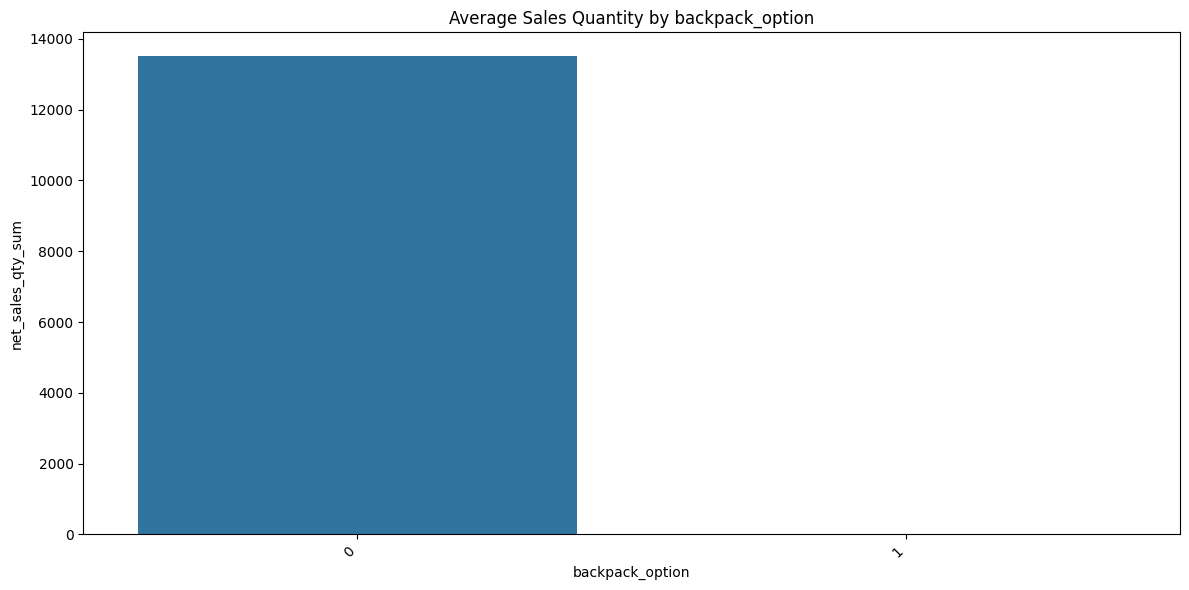

   backpack_option  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0            13508.4           1.701271e+06   
1                1                0.0           7.760000e+00   

   max_qty_sold_at_store  
0                 6796.8  
1                    0.0  

Top 5 wristlet_option categories by sales:


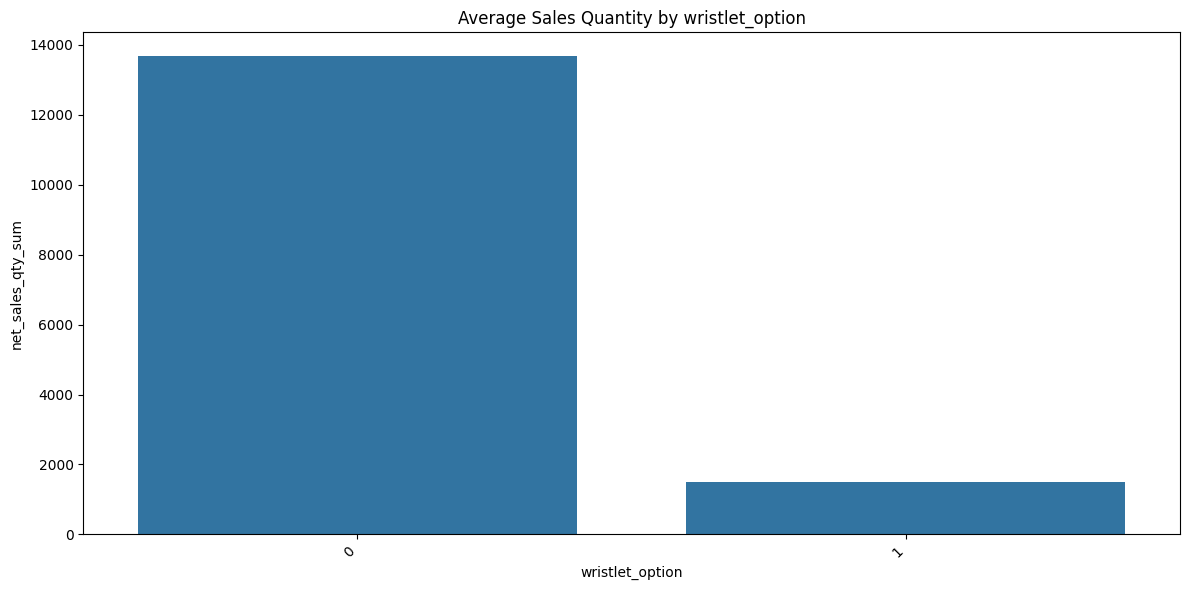

   wristlet_option  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0       13674.555556           1.725653e+06   
1                1        1512.000000           1.282351e+05   

   max_qty_sold_at_store  
0            6865.703704  
1            1025.333333  

Top 5 wallet_function categories by sales:


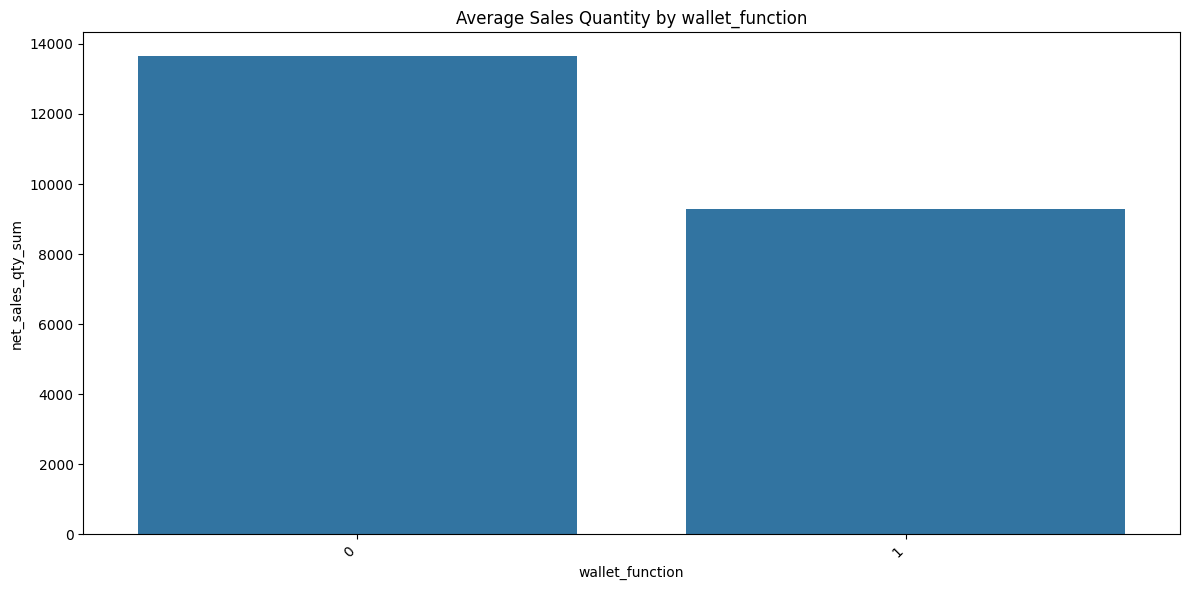

   wallet_function  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                0       13646.061224           1.807916e+06   
1                1        9288.125000           6.227574e+05   

   max_qty_sold_at_store  
0            7024.938776  
1            3700.250000  

Top 5 phone_compatibility categories by sales:


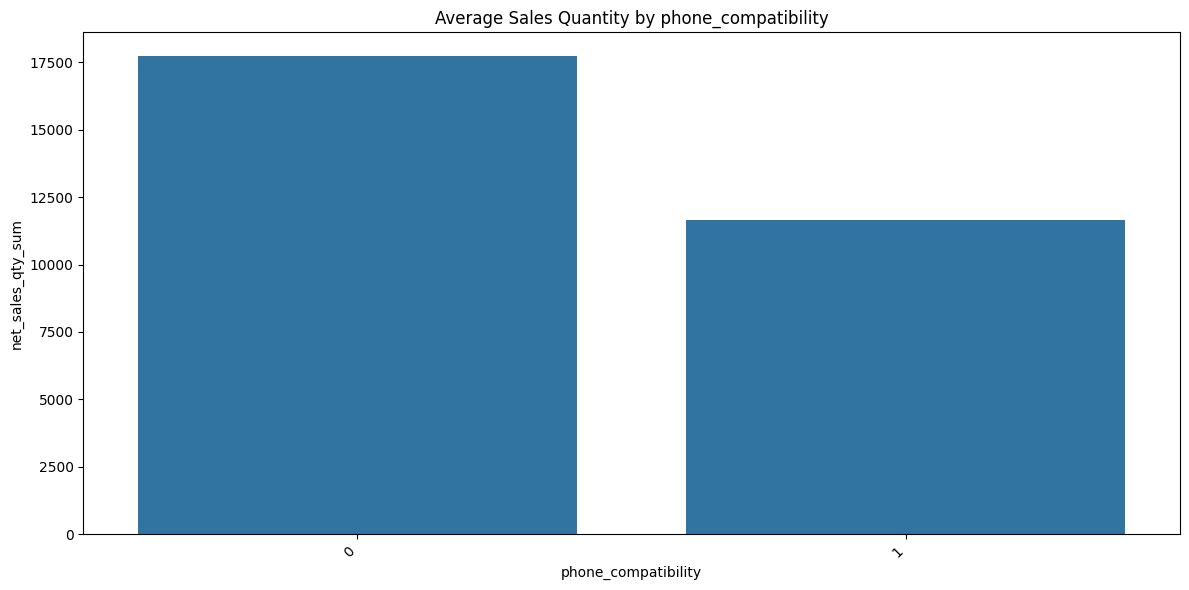

   phone_compatibility  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                    0       17717.692308           1.839194e+06   
1                    1       11650.727273           1.583191e+06   

   max_qty_sold_at_store  
0           11203.384615  
1            5185.909091  

Top 5 tablet_compatibility categories by sales:


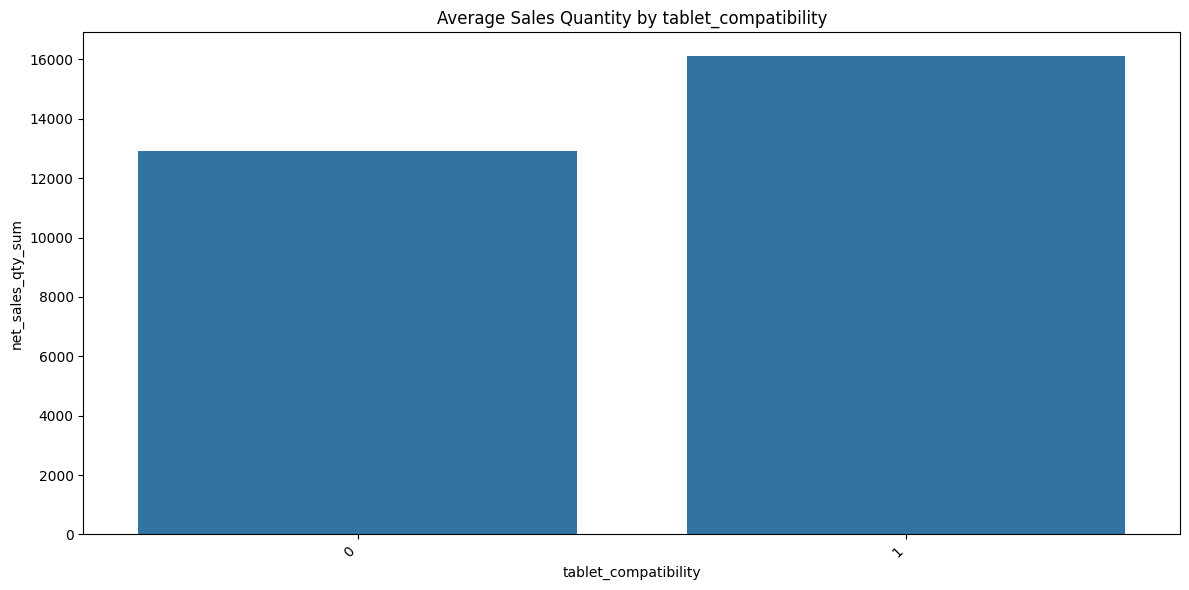

   tablet_compatibility  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                     1       16106.000000           2.595845e+06   
0                     0       12922.727273           1.606877e+06   

   max_qty_sold_at_store  
1            8979.000000  
0            6470.290909  

Top 5 novelty_shape categories by sales:


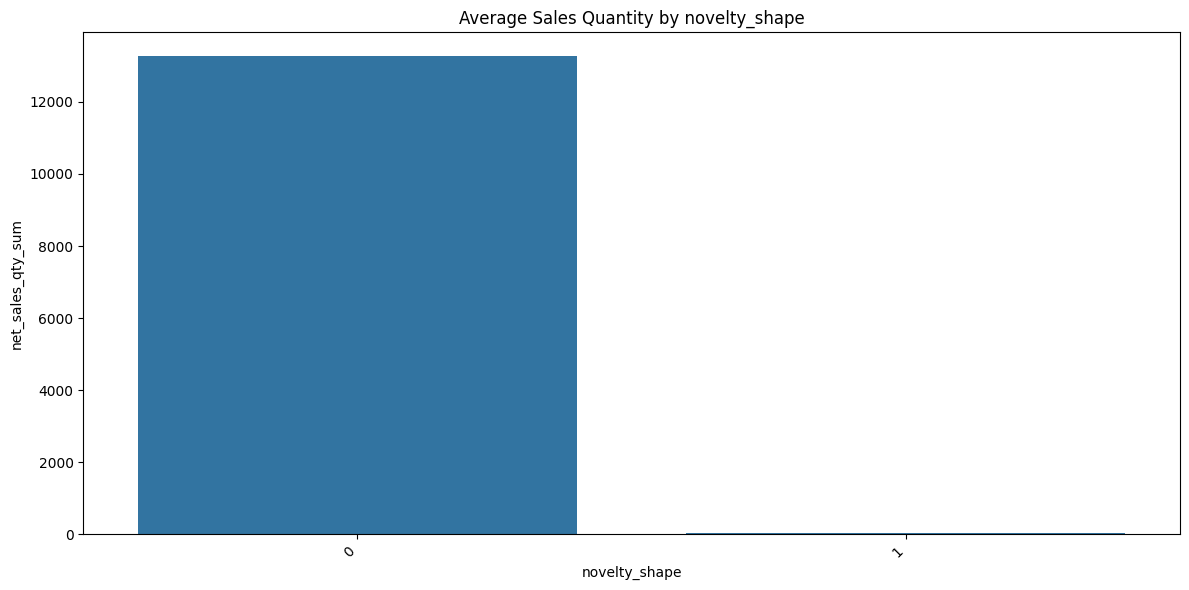

   novelty_shape  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0              0       13266.642857           1.670822e+06   
1              1          30.000000           3.912300e+03   

   max_qty_sold_at_store  
0            6675.196429  
1              13.000000  

Top 5 eco_friendly_material categories by sales:


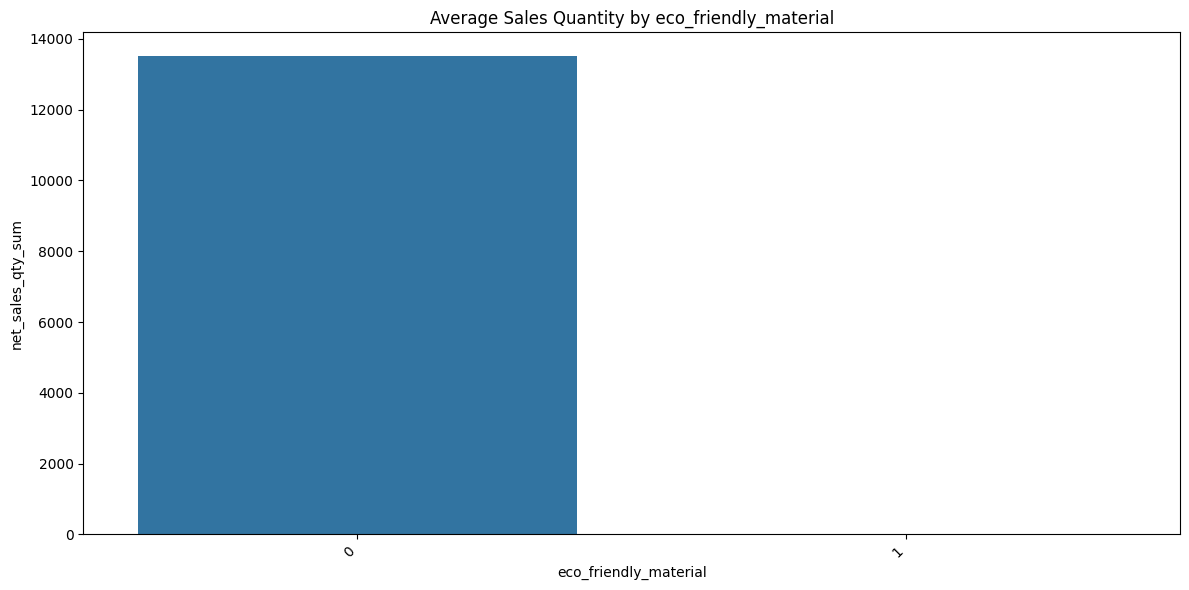

   eco_friendly_material  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                      0       13508.272727           1.701264e+06   
1                      1           3.500000           2.185400e+02   

   max_qty_sold_at_store  
0            6796.727273  
1               2.000000  

Top 5 snap_button_closure categories by sales:


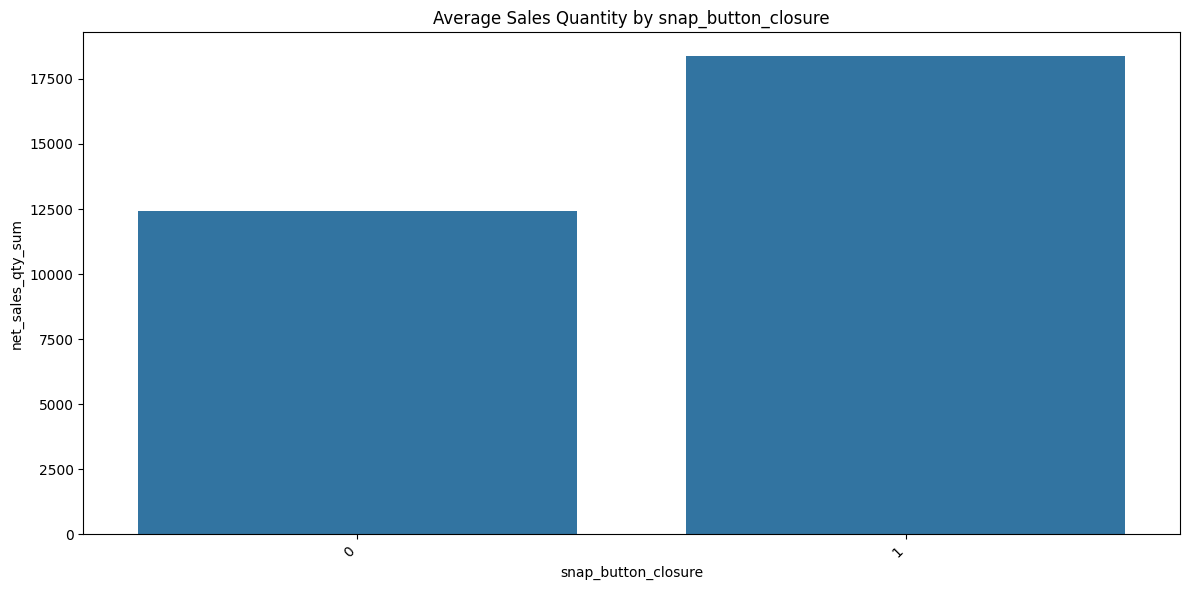

   snap_button_closure  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                    1       18371.500000             1721436.04   
0                    0       12406.529412             1632182.89   

   max_qty_sold_at_store  
1            6941.500000  
0            6513.235294  

Top 5 charm_attachment_point categories by sales:


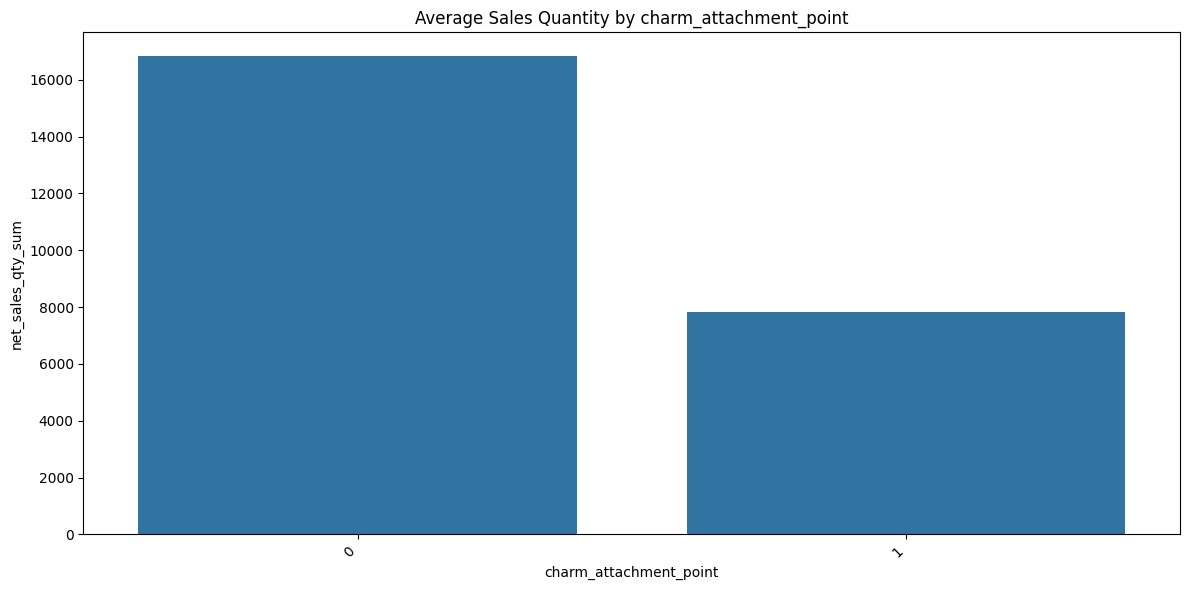

   charm_attachment_point  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0                       0       16826.363636           2.105747e+06   
1                       1        7820.500000           1.003345e+06   

   max_qty_sold_at_store  
0            8087.575758  
1            4455.583333  

Top 5 hidden_pocket categories by sales:


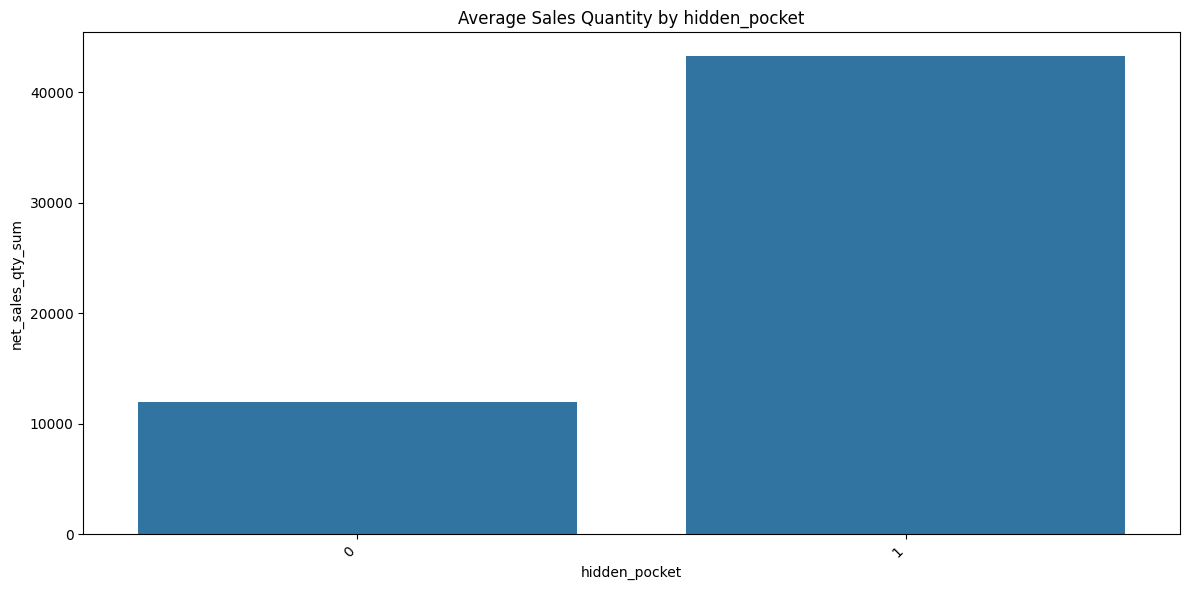

   hidden_pocket  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1              1       43262.000000           5.664368e+06   
0              0       11935.236364           1.495295e+06   

   max_qty_sold_at_store  
1           15071.000000  
0            6248.763636  

Top 5 logo_placement categories by sales:


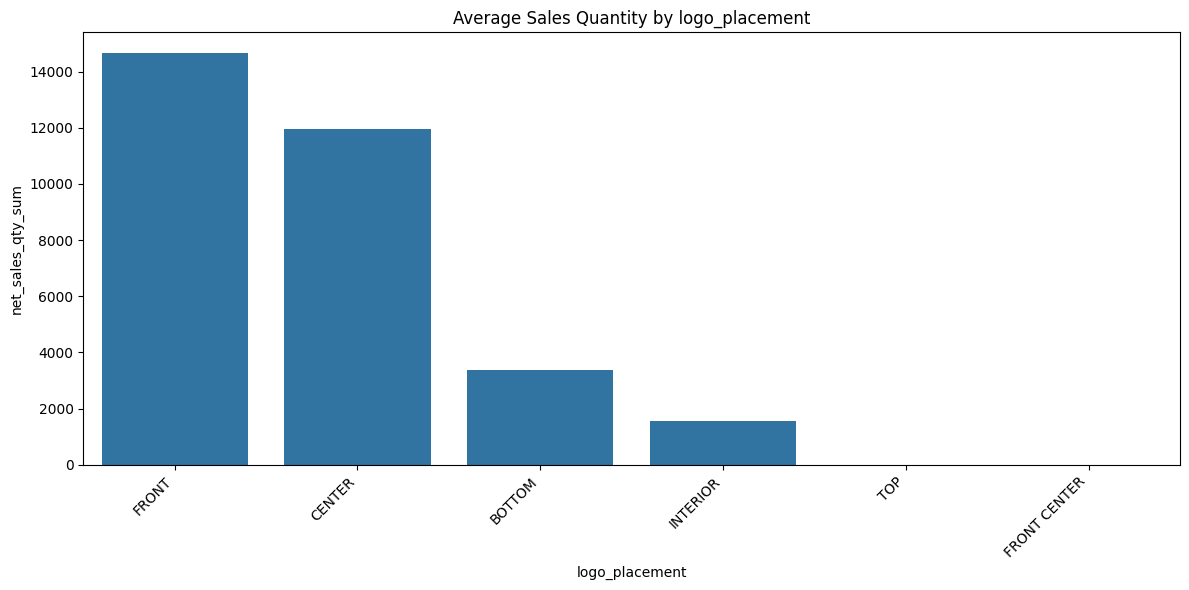

  logo_placement  net_sales_qty_sum  net_sales_amt_lcl_sum  \
2          FRONT       14663.375000           1.879500e+06   
1         CENTER       11939.555556           1.579576e+06   
0         BOTTOM        3376.500000           4.446230e+05   
4       INTERIOR        1562.000000           1.931721e+05   
5            TOP           3.000000           1.676200e+02   

   max_qty_sold_at_store  
2            7990.500000  
1            4794.138889  
0            2122.500000  
4            1205.000000  
5               3.000000  

Top 5 logo_style categories by sales:


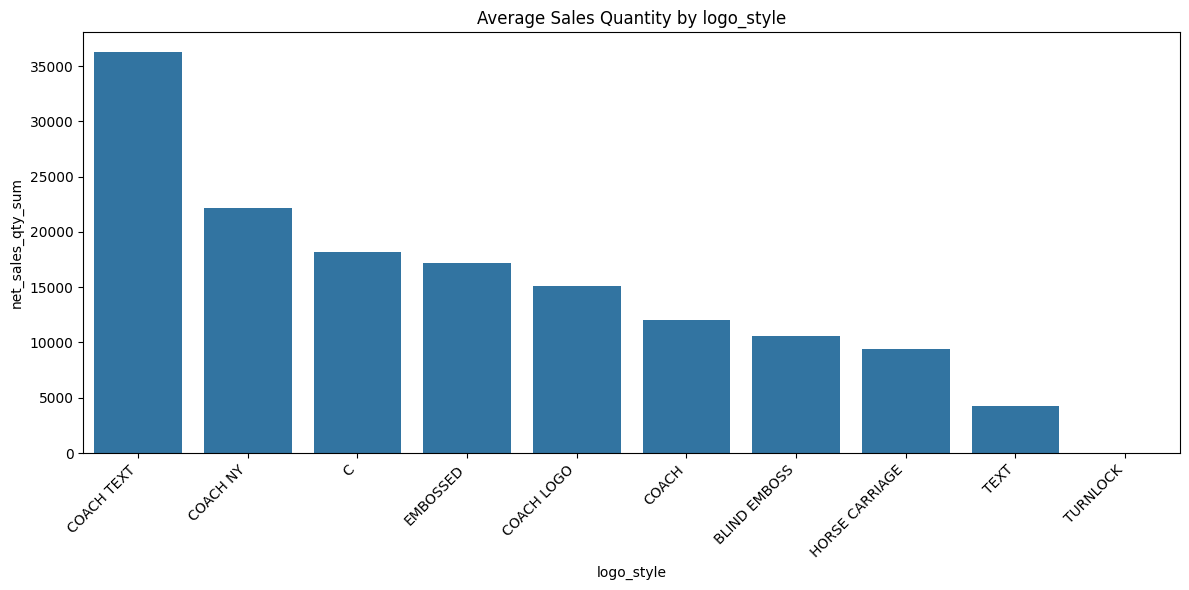

   logo_style  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
5  COACH TEXT           36254.00           5.253843e+06                13234.0
4    COACH NY           22173.00           2.066597e+06                 9370.0
1           C           18200.75           2.506245e+06                 5249.5
6    EMBOSSED           17193.00           1.437483e+06                 5589.0
3  COACH LOGO           15101.00           2.880889e+06                 7803.5

Top 5 logo_type categories by sales:


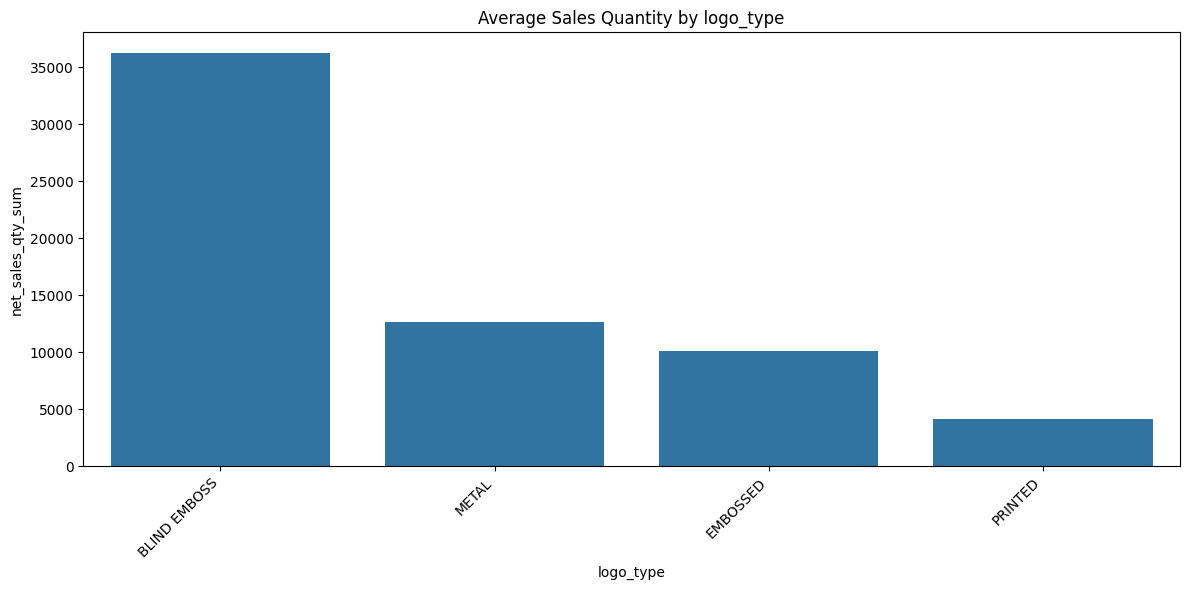

      logo_type  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0  BLIND EMBOSS       36254.000000           5.253843e+06   
2         METAL       12658.944444           1.675294e+06   
1      EMBOSSED       10106.750000           1.312648e+06   
3       PRINTED        4168.000000           4.085354e+05   

   max_qty_sold_at_store  
0           13234.000000  
2            5120.888889  
1            4766.821429  
3            1546.000000  

Top 5 is_symmetrical categories by sales:


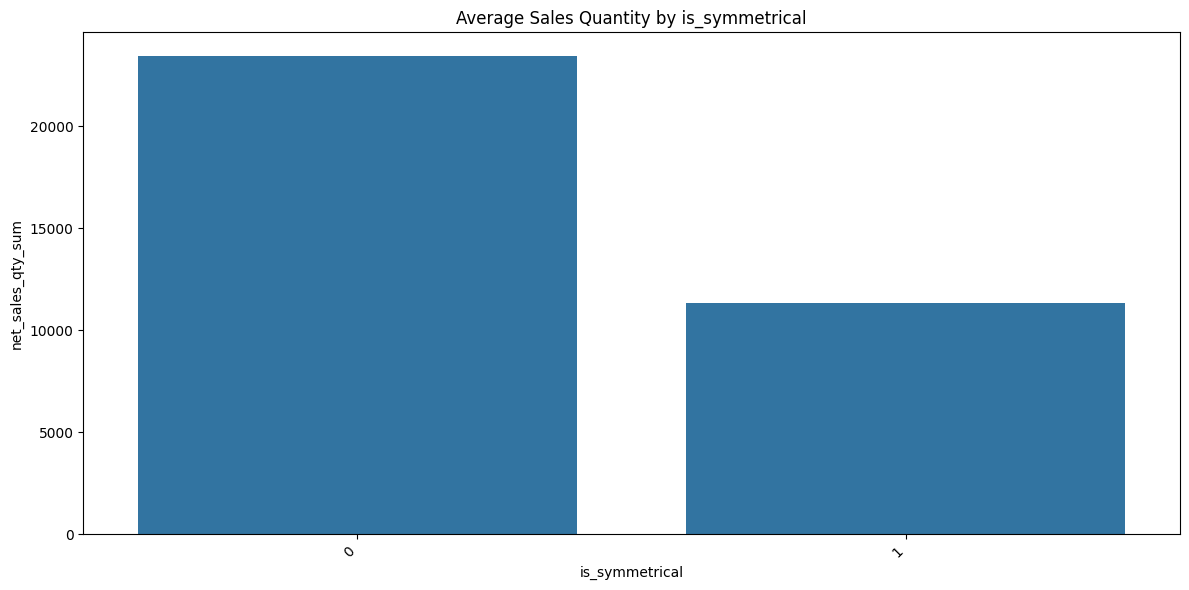

   is_symmetrical  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0               0       23436.875000           2.573230e+06   
1               1       11336.061224           1.489471e+06   

   max_qty_sold_at_store  
0           16480.125000  
1            4938.428571  

Top 5 exposed_zipper categories by sales:


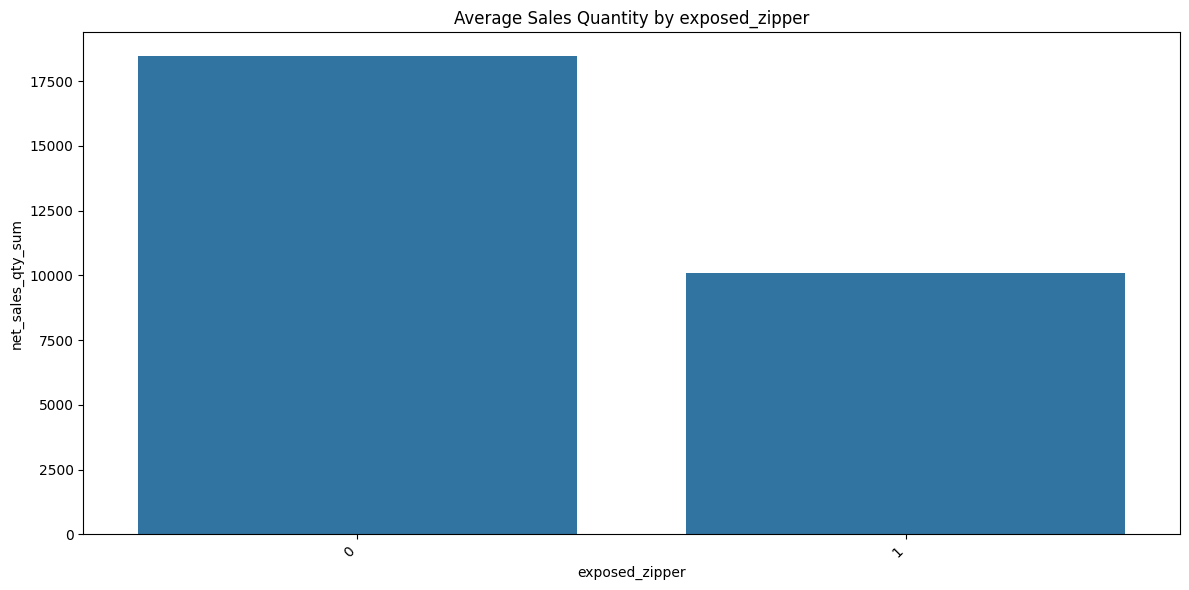

   exposed_zipper  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0               0       18458.600000           2.156567e+06   
1               1       10102.432432           1.363205e+06   

   max_qty_sold_at_store  
0           10368.350000  
1            4498.837838  

Top 5 is_slouchy categories by sales:


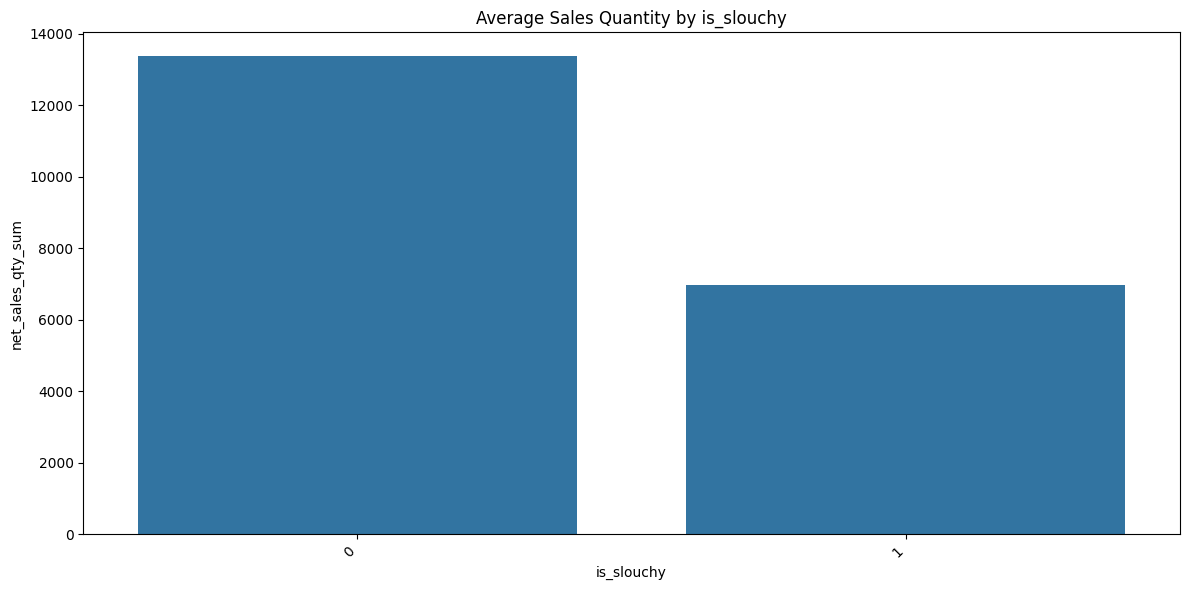

   is_slouchy  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
0           0       13370.740741           1.656335e+06            6797.555556
1           1        6980.666667           1.375946e+06            2252.000000

Top 5 gusseted_pocket categories by sales:


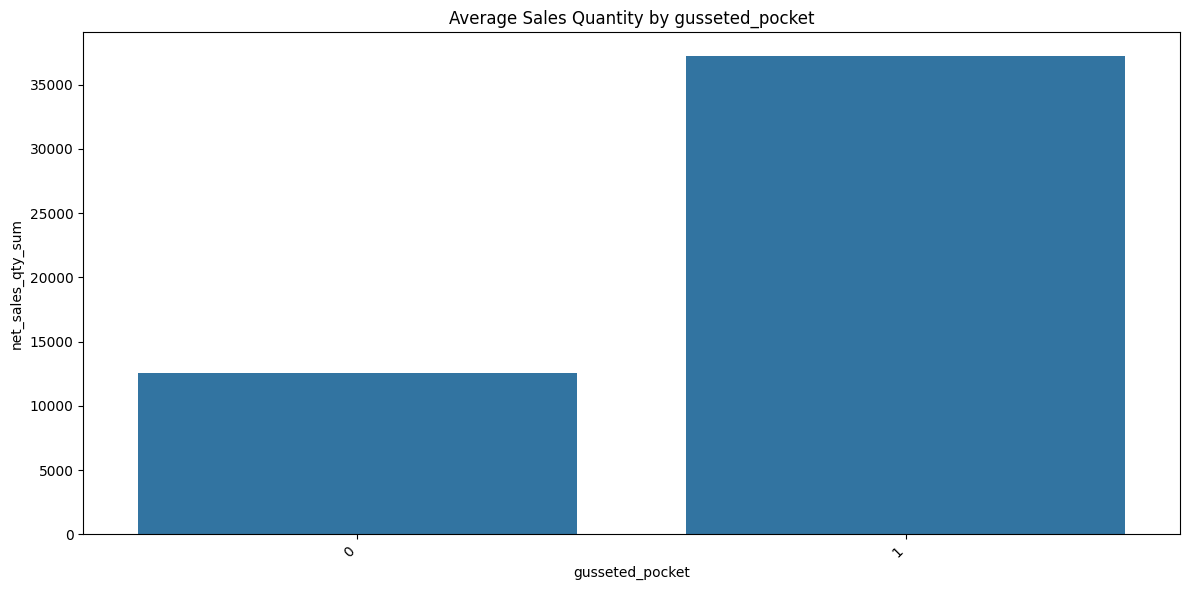

   gusseted_pocket  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                1       37220.000000           3.916454e+06   
0                0       12602.535714           1.600955e+06   

   max_qty_sold_at_store  
1                27884.0  
0                 6177.5  

Top 5 finish_type categories by sales:


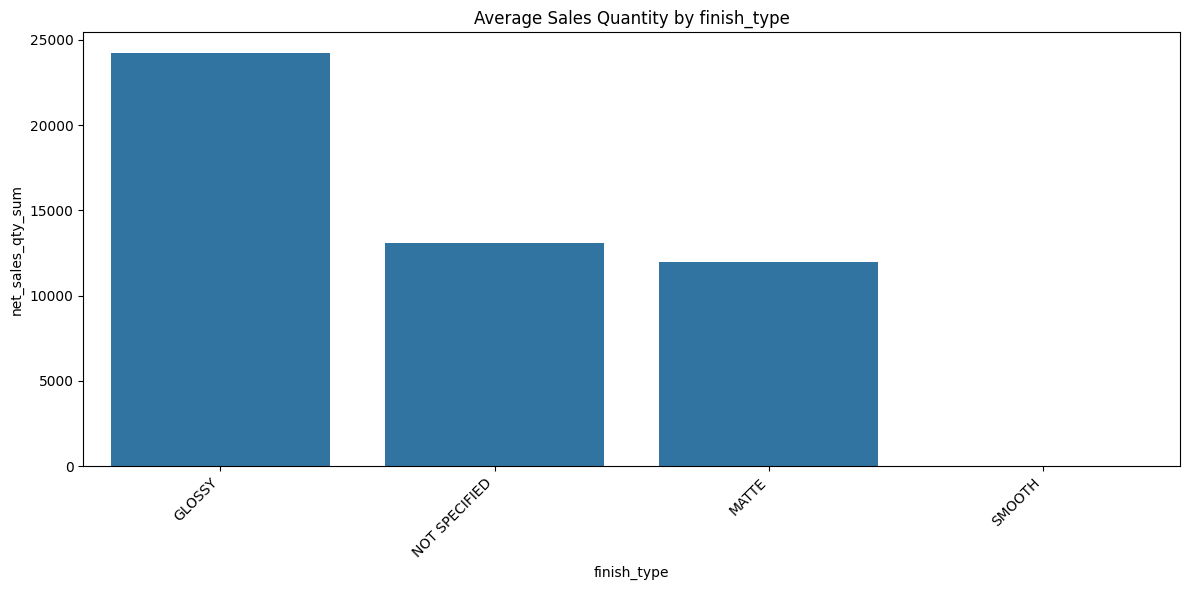

     finish_type  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0         GLOSSY       24228.000000            4623340.860   
2  NOT SPECIFIED       13061.333333            1537955.070   
1          MATTE       11988.578947            1595176.615   
3         SMOOTH           4.000000                269.460   

   max_qty_sold_at_store  
0           12211.000000  
2            5581.333333  
1            5041.657895  
3               1.000000  

Top 5 print_pattern categories by sales:


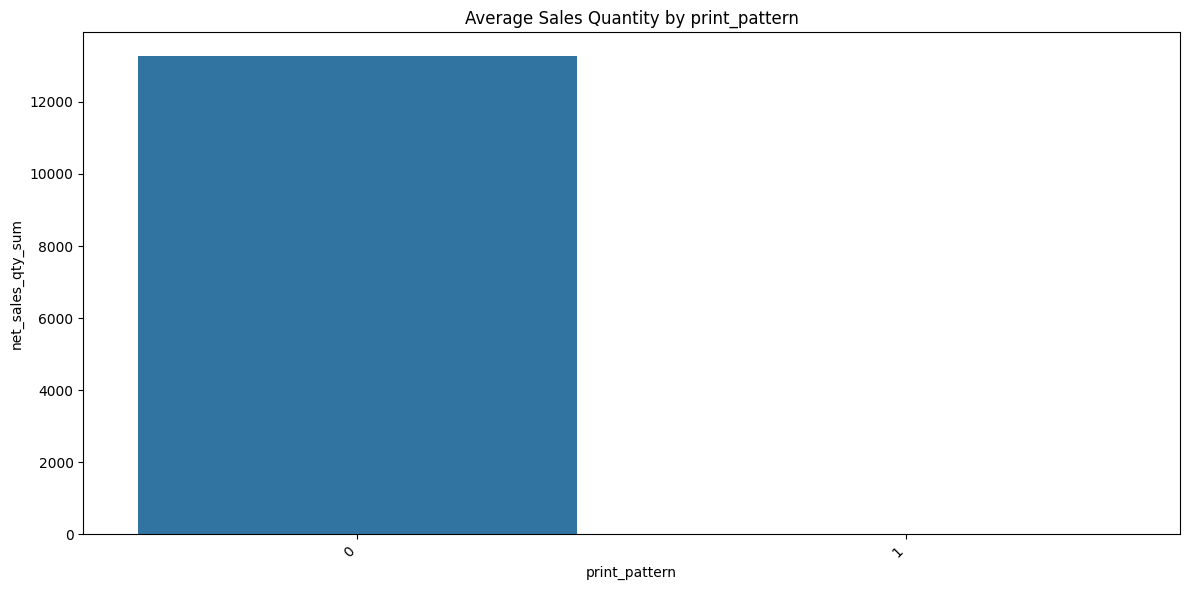

   print_pattern  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0              0          13267.125           1.670889e+06   
1              1              3.000           1.676200e+02   

   max_qty_sold_at_store  
0               6675.375  
1                  3.000  

Top 5 grommet_count categories by sales:


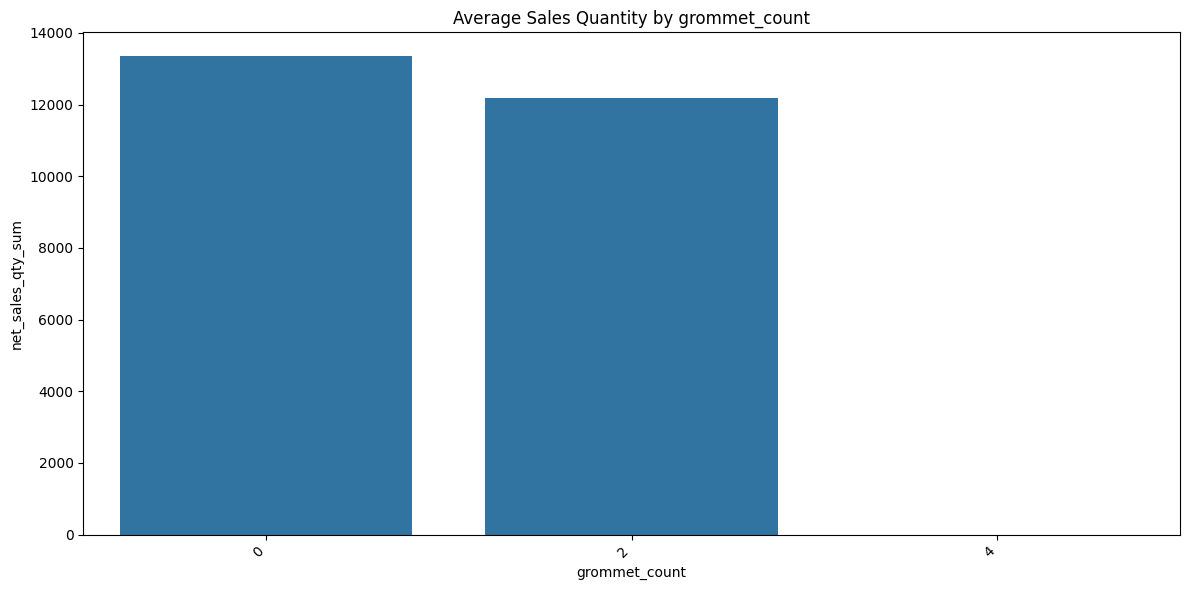

   grommet_count  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0              0       13350.269231           1.646786e+06   
1              2       12187.000000           1.984264e+06   
2              4           0.000000           0.000000e+00   

   max_qty_sold_at_store  
0            6696.288462  
1            6404.250000  
2               0.000000  

Top 5 department_desc categories by sales:


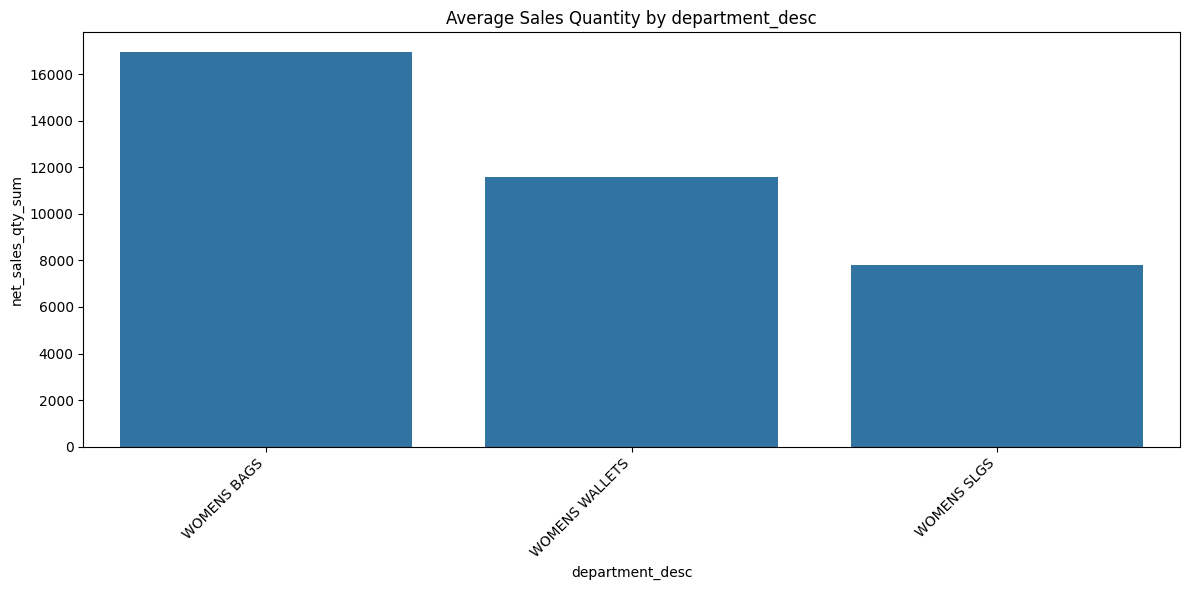

  department_desc  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0     WOMENS BAGS       16943.387097           2.357522e+06   
2  WOMENS WALLETS       11595.500000           8.736134e+05   
1     WOMENS SLGS        7787.954545           7.723781e+05   

   max_qty_sold_at_store  
0            8359.741935  
2            3749.500000  
1            4530.636364  

Top 5 class categories by sales:


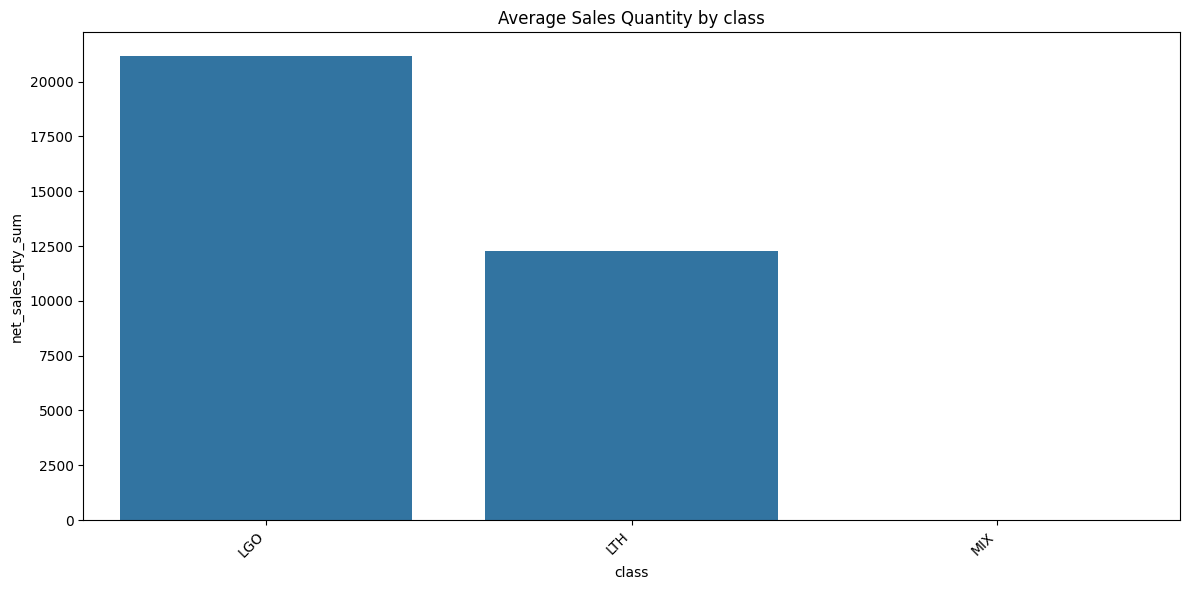

  class  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
0   LGO       21191.000000           2.146170e+06           14480.555556
1   LTH       12271.933333           1.650091e+06            5410.955556
2   MIX           2.000000           1.117467e+02               2.000000

Top 5 subclass categories by sales:


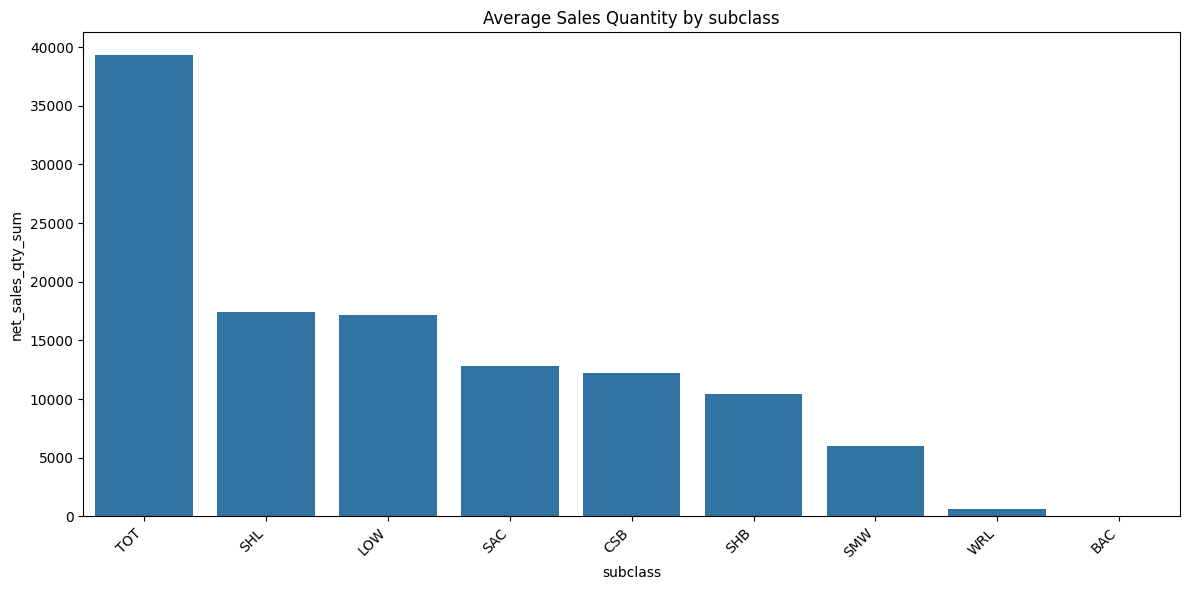

  subclass  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
7      TOT       39286.000000           4.322718e+06           28196.500000
5      SHL       17452.400000           2.687219e+06            6464.200000
2      LOW       17193.000000           1.437483e+06            5589.000000
3      SAC       12786.500000           6.893959e+05            6782.000000
1      CSB       12222.444444           1.562823e+06            5949.777778

Top 5 collection categories by sales:


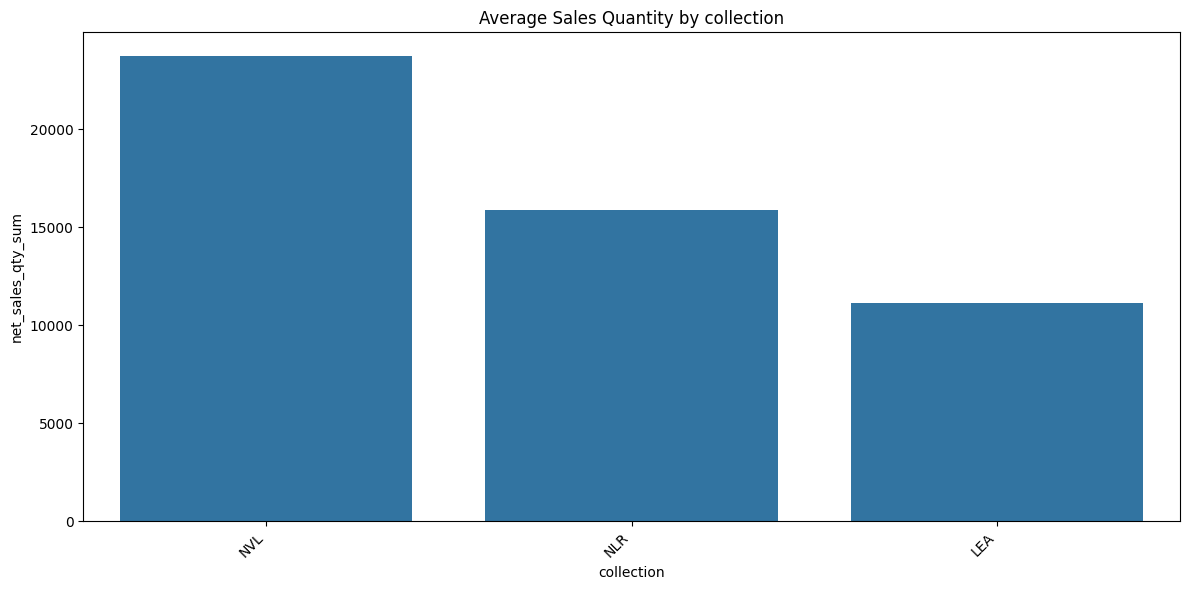

  collection  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
2        NVL       23752.000000           3.275887e+06            9419.250000
1        NLR       15893.750000           1.609655e+06           10860.916667
0        LEA       11151.926829           1.491476e+06            5019.902439

Top 5 subcollection categories by sales:


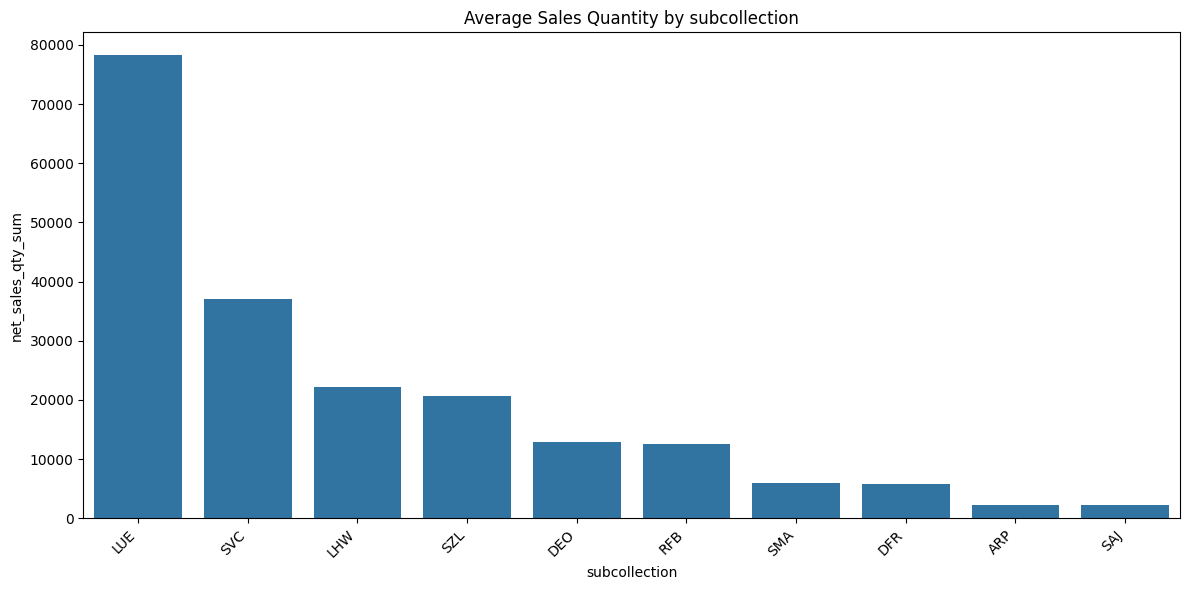

   subcollection  net_sales_qty_sum  net_sales_amt_lcl_sum  \
7            LUE            78207.0           1.162587e+07   
14           SVC            37033.4           3.744143e+06   
6            LHW            22160.5           2.527070e+06   
15           SZL            20619.5           3.585317e+06   
3            DEO            12910.0           1.176629e+06   

    max_qty_sold_at_store  
7            31013.000000  
14           25464.400000  
6            13066.833333  
15            9792.500000  
3             4439.000000  

Top 5 material categories by sales:


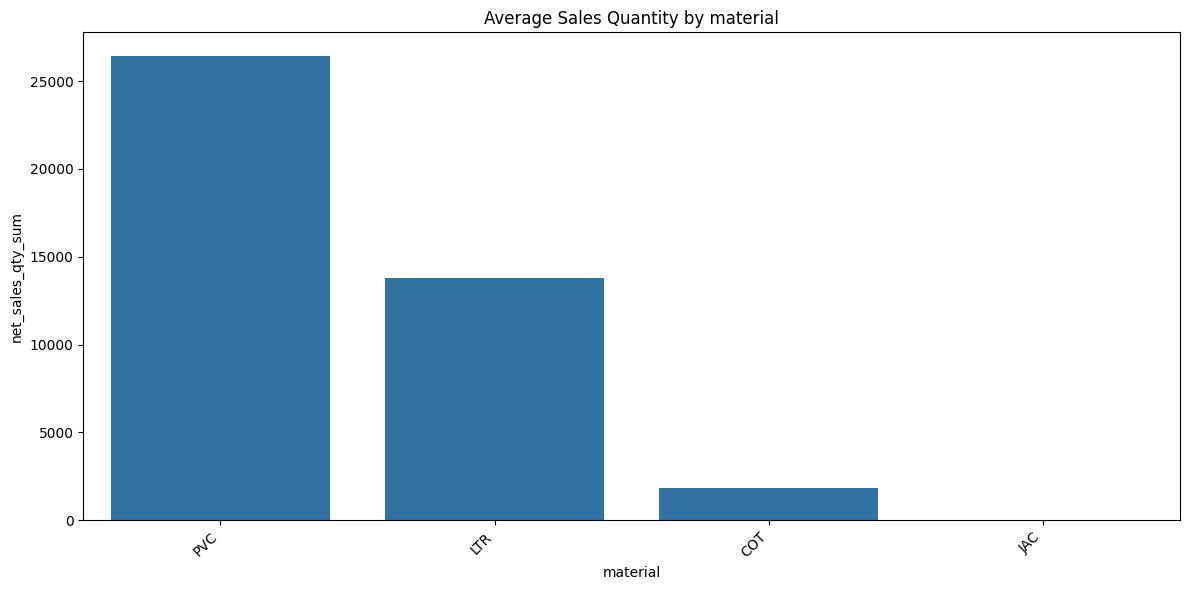

  material  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
3      PVC       26453.285714           2.674436e+06           18189.714286
2      LTR       13762.075000           1.850958e+06            6056.475000
0      COT        1856.666667           1.985834e+05            1003.333333
1      JAC           0.000000          -1.000000e-02               0.000000

Top 5 material_type_y categories by sales:


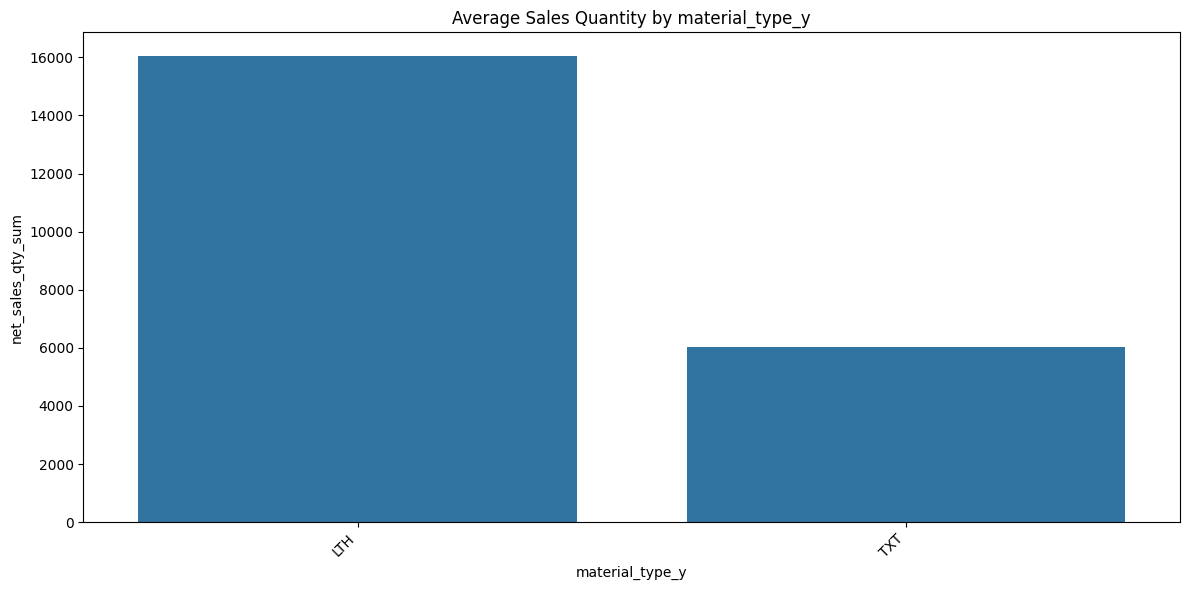

  material_type_y  net_sales_qty_sum  net_sales_amt_lcl_sum  \
0             LTH       16057.515152           2.157057e+06   
1             TXT        6027.600000           4.684680e+05   

   max_qty_sold_at_store  
0            7073.878788  
1            3552.200000  

Top 5 collaboration categories by sales:


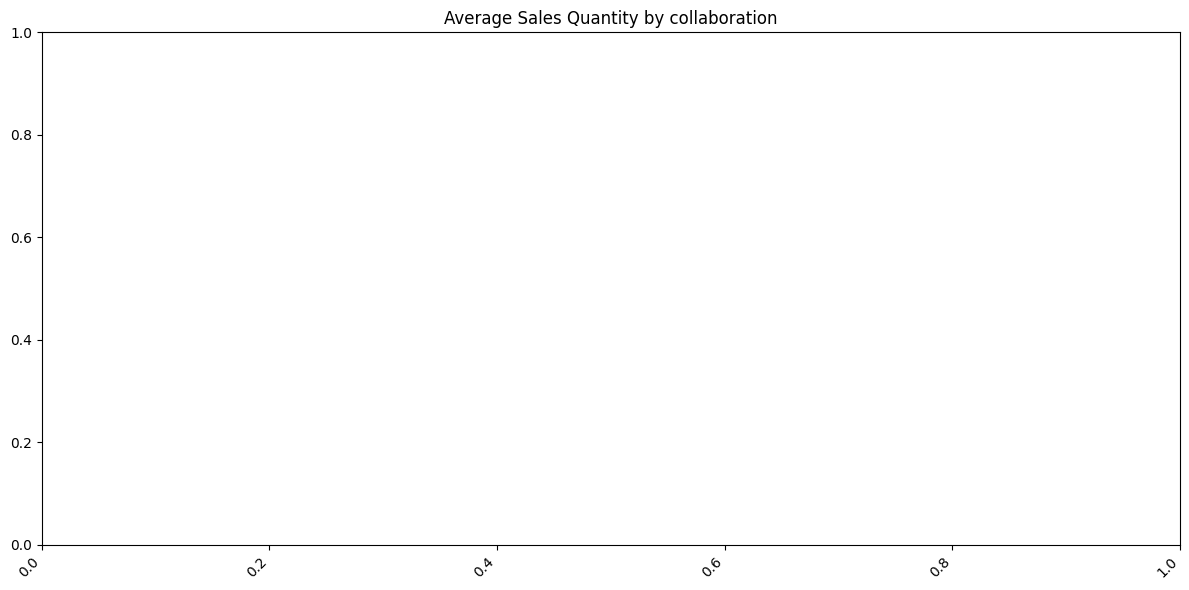

Empty DataFrame
Columns: [collaboration, net_sales_qty_sum, net_sales_amt_lcl_sum, max_qty_sold_at_store]
Index: []

Top 5 silhouette categories by sales:


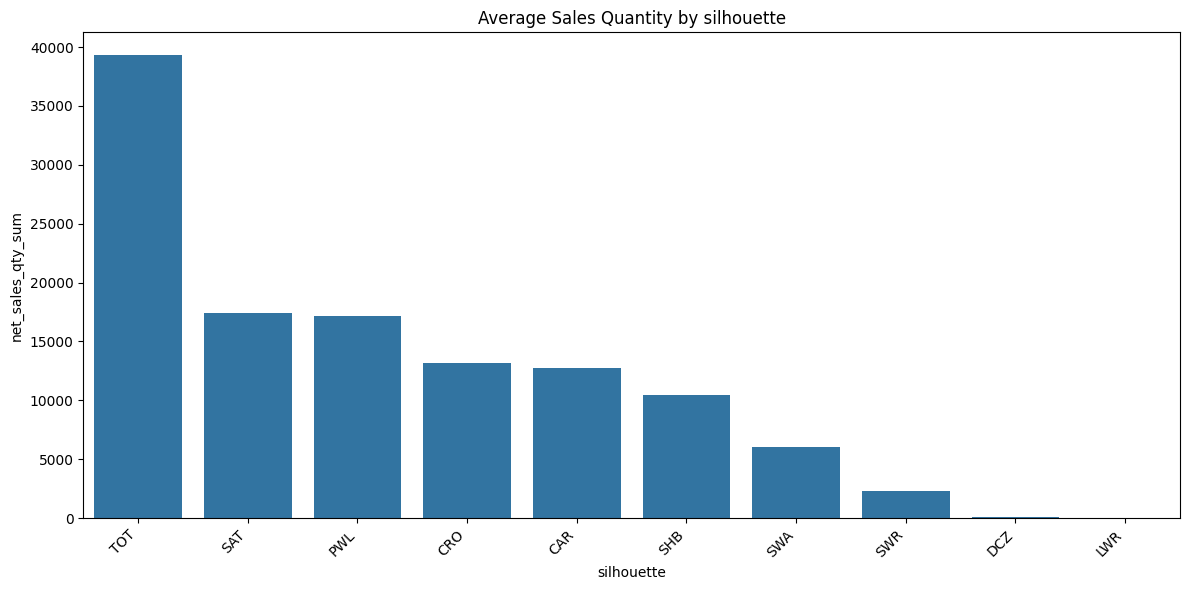

   silhouette  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
11        TOT           39286.00           4.322718e+06               28196.50
7         SAT           17452.40           2.687219e+06                6464.20
6         PWL           17193.00           1.437483e+06                5589.00
2         CRO           13199.92           1.687827e+06                6425.68
1         CAR           12786.50           6.893959e+05                6782.00

Top 5 active categories by sales:


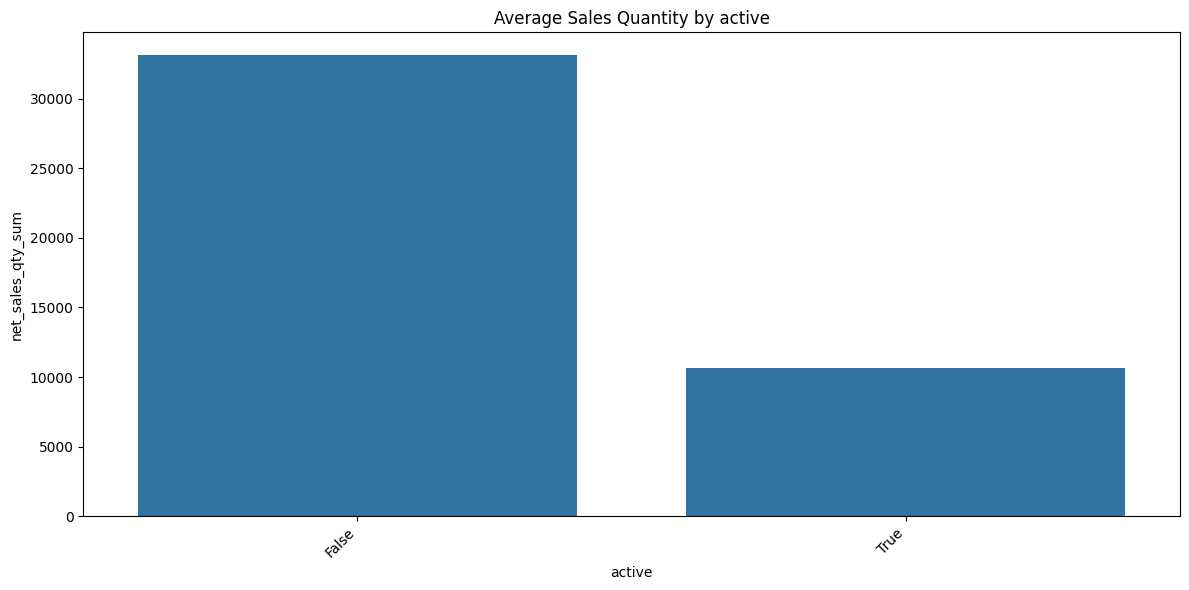

   active  net_sales_qty_sum  net_sales_amt_lcl_sum  max_qty_sold_at_store
0   False       33117.666667           3.877921e+06           21645.500000
1    True       10671.686275           1.378479e+06            4783.352941

Top 5 color_count categories by sales:


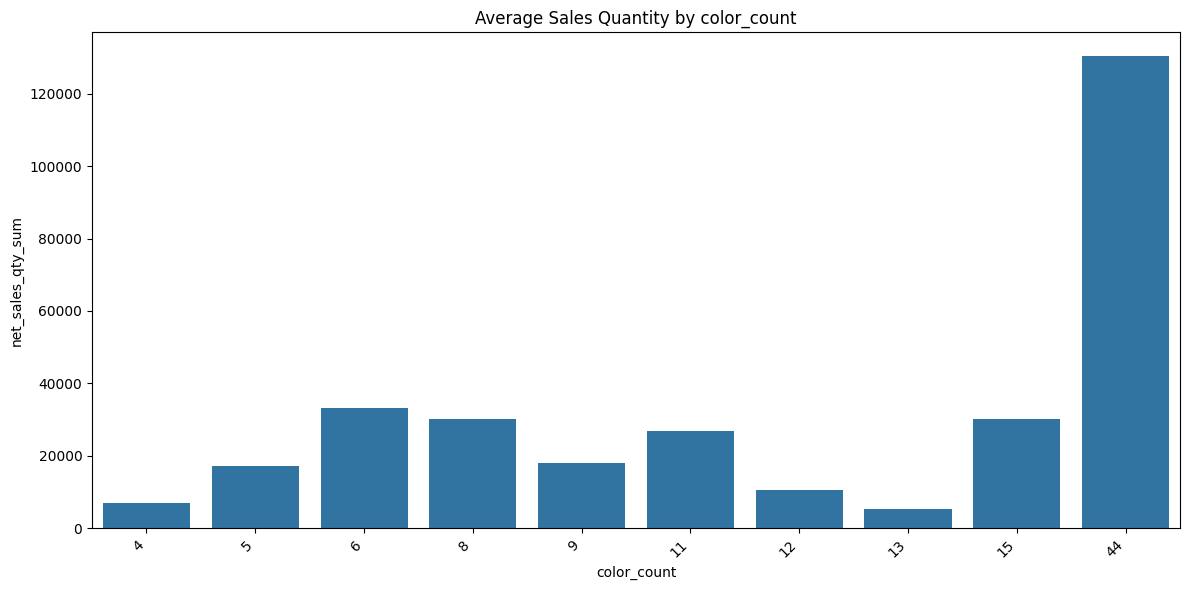

    color_count  net_sales_qty_sum  net_sales_amt_lcl_sum  \
15           44      130467.000000           1.463212e+07   
5             6       33201.500000           3.967126e+06   
7             8       30202.000000           5.761756e+06   
13           15       30145.000000           3.742210e+06   
9            11       26849.333333           3.978625e+06   

    max_qty_sold_at_store  
15           94816.000000  
5            12390.500000  
7            15607.000000  
13            8586.666667  
9            10366.333333  


In [116]:


# Function to analyze sales by categorical feature
def analyze_categorical_feature(feature):
    # Group by feature and calculate mean sales
    grouped = df.groupby(feature)[sales_cols].mean().reset_index()
    grouped = grouped.sort_values('net_sales_qty_sum', ascending=False)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature, y='net_sales_qty_sum', data=grouped.head(10))
    plt.title(f'Average Sales Quantity by {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Return top categories
    return grouped.head(5)

# Analyze each categorical feature
for feature in cat_features:
    if df[feature].nunique() < 20:  # Only analyze if not too many unique values
        print(f"\nTop 5 {feature} categories by sales:")
        print(analyze_categorical_feature(feature))

## Advanced Analysis: Predictive Modeling


## Analysis of Low-Selling Products


In [75]:
# df['net_sales_qty_sum'].sort_values(ascending=False)

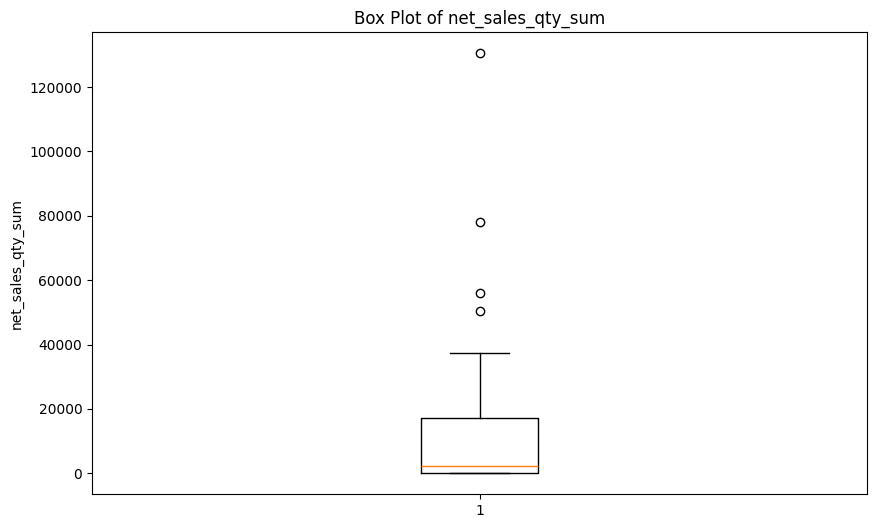

In [76]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['net_sales_qty_sum'])
plt.title('Box Plot of net_sales_qty_sum')
plt.ylabel('net_sales_qty_sum')
plt.show()

In [77]:
df['net_sales_qty_sum'].quantile(0.44)


np.float64(1300.8799999999997)

In [78]:
df['net_sales_qty_sum'].median()

np.float64(2282.0)

In [79]:
# Define low-selling products (bottom 25%)
sales_threshold = df['net_sales_qty_sum'].quantile(0.44)
# sales_threshold = df['net_sales_qty_sum'].median()

low_selling = df[df['net_sales_qty_sum'] <= sales_threshold]
low_selling

,bag_height,bag_width,top_opening_width,gusset_width,handle_drop_length,long_strap_drop_length,logo_size,material_type_x,opener_design,opener_material,...,style_group,active,color_count,net_sales_qty_sum,net_sales_amt_lcl_sum,qtr_highest_sale_qty,qtr_highest_sale_amt,store_highest_sale,max_qty_sold_at_store,price_per_item
2,11.5,25.8,25.8,9.0,23.0,23.00,3.0,LEATHER,ZIPPER,METAL,...,ARIASHOULDERBAG,True,2,77,8053.09,1,1,3808,21,104.585584
3,7.7,11.8,11.8,0.0,0.0,0.00,1.0,CROSSGRAIN LEATHER,ZIPPER,METAL,...,ATTACHMENTCARDCASE,True,5,0,33.03,1,1,3802,1,NaN
7,25.7,27.0,27.0,7.0,0.0,63.50,0.0,LEATHER,ZIPPER,METAL,...,DEMPSEYFILEBAG,True,3,0,5.17,1,1,3802,0,NaN
10,18.8,20.0,20.0,6.7,0.0,55.00,2.0,LEATHER,ZIPPER,METAL,...,HADLEYMINICROSSBODY,True,4,227,40050.50,3,3,ECCHECFA,101,176.433921
13,10.2,17.8,17.8,5.0,10.5,0.00,0.0,LEATHER,ZIPPER,METAL,...,JAMIEWRISTLET,True,5,21,934.12,1,1,5141,20,44.481905
14,15.0,23.0,23.0,8.2,0.0,56.00,3.0,LEATHER,ZIPPER,METAL,...,MADICROSSBODY,True,4,1,82.49,2,2,4011,1,82.490000
16,9.3,15.5,15.5,3.9,126.0,NaN,2.0,LEATHER,FLAP,LEATHER,...,BRIEMINICROSSBODY,True,1,4,269.46,1,2,3810,1,67.365000
22,12.5,19.5,19.5,6.2,0.0,57.00,3.0,CHERRY PRINT,ZIPPER,METAL,...,MINIJAMIECAMERABAG,True,1,3,167.62,1,1,ECCHECFA,3,55.873333
27,8.5,19.5,19.5,8.5,17.0,0.00,3.0,LEATHER,ZIPPER,METAL,...,NOLITABARRELBAG,True,1,19,1020.98,1,1,ECCHECFA,8,53.735789
30,22.0,34.0,26.5,9.5,12.7,56.00,2.0,LEATHER,ZIPPER,METAL,...,PRAIRIESATCHEL,True,48,0,-37.13,1,1,3802,1,NaN


In [80]:
# Compare characteristics of low-selling vs high-selling products
high_selling = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].quantile(0.50)]
# high_selling

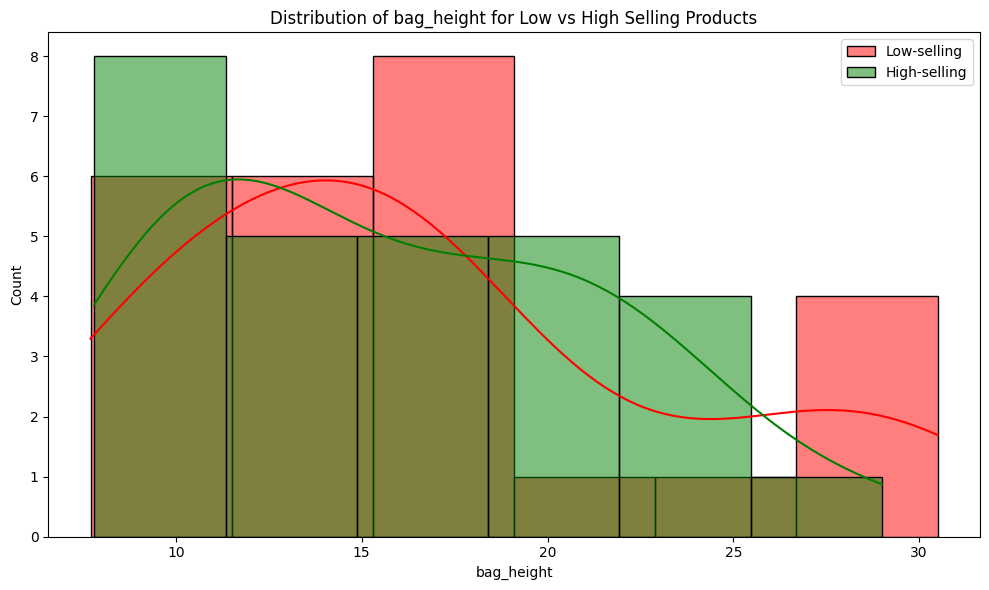

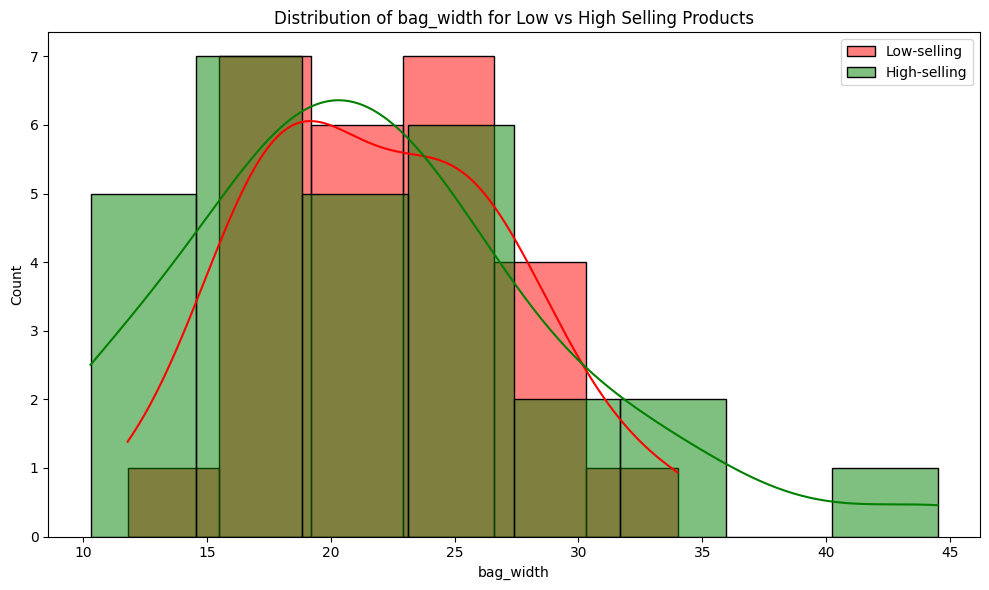

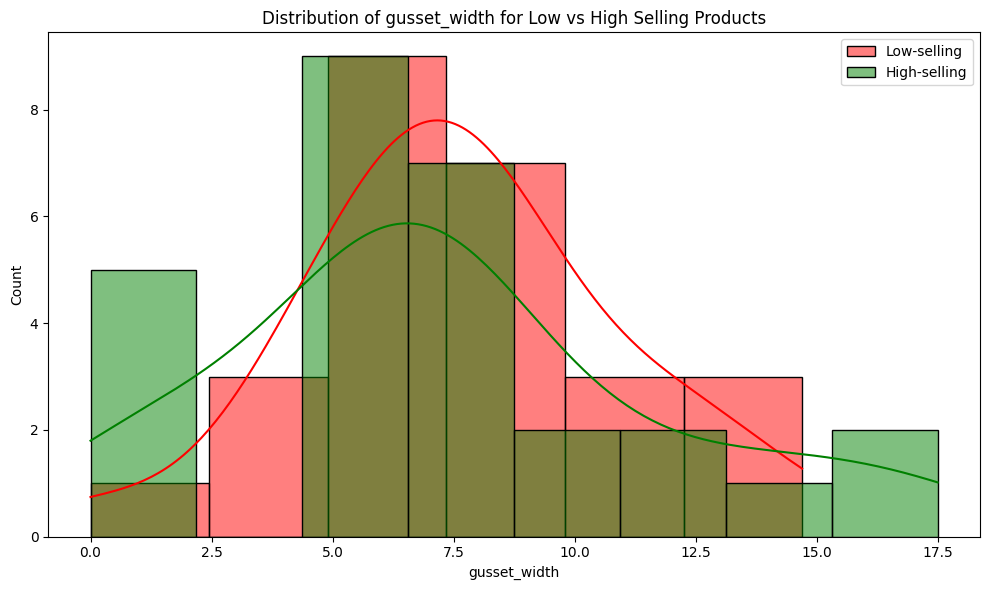

<Figure size 1000x600 with 0 Axes>

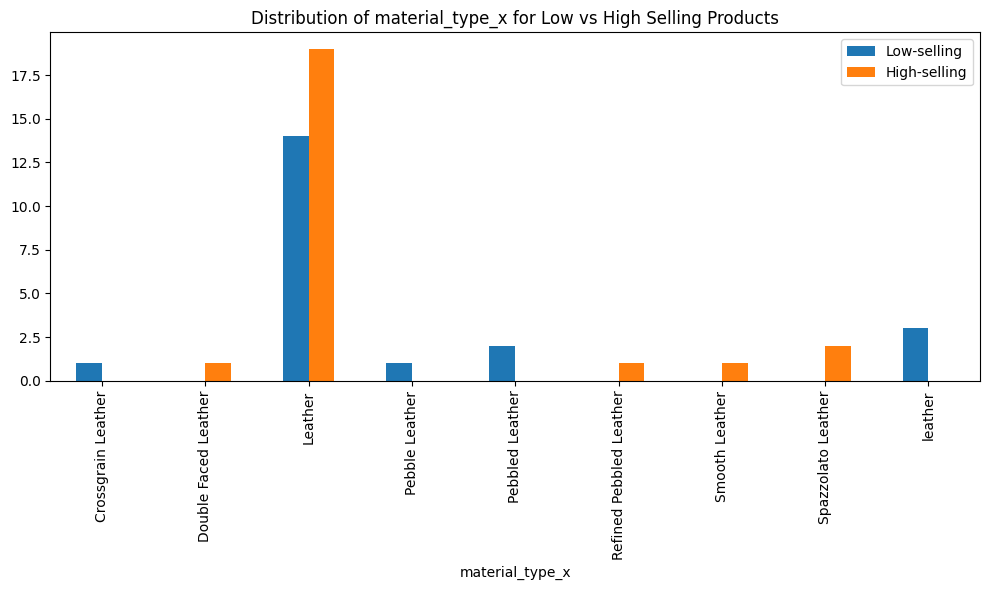

<Figure size 1000x600 with 0 Axes>

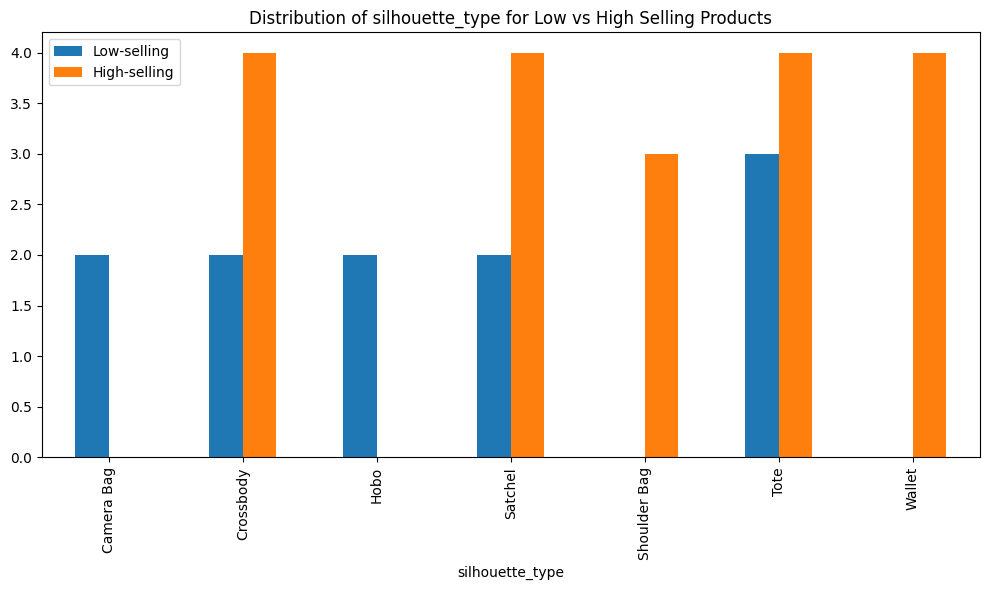

<Figure size 1000x600 with 0 Axes>

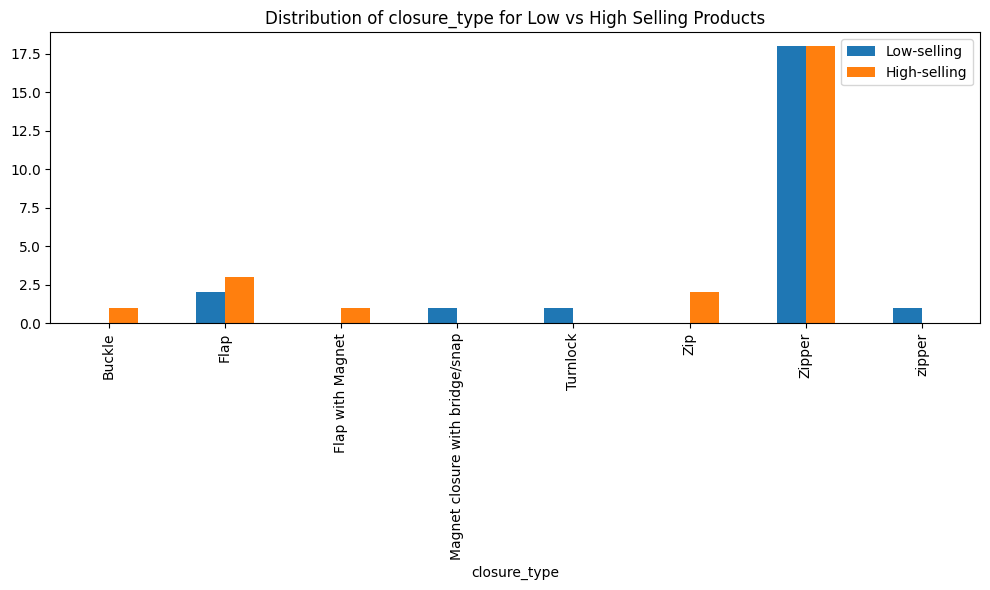

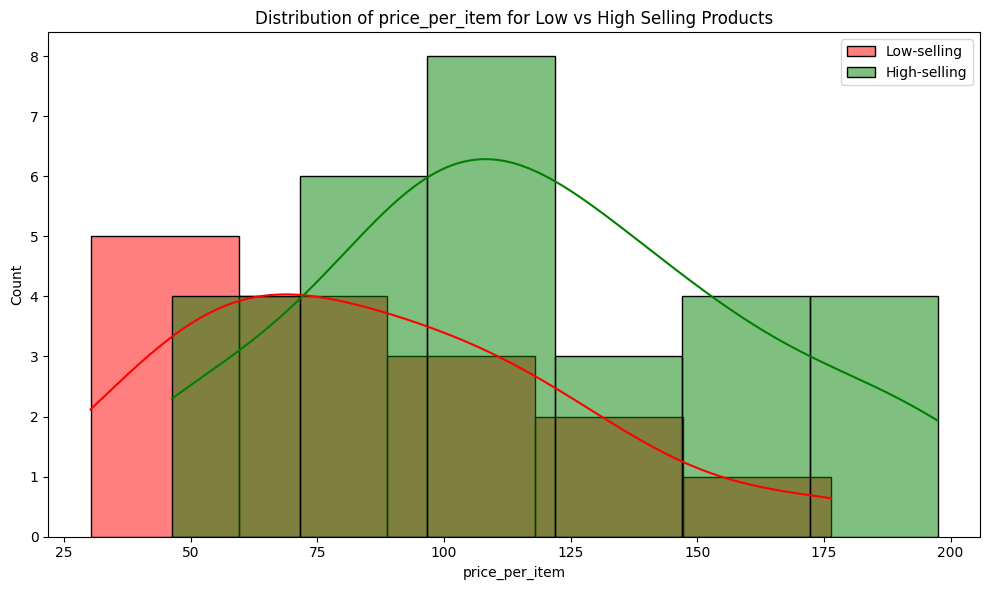

Statistical comparison of low vs high selling products:
bag_height: Low-selling mean: 16.59, High-selling mean: 15.78, p-value: 0.6369, Not significant
bag_width: Low-selling mean: 22.00, High-selling mean: 21.66, p-value: 0.8526, Not significant
top_opening_width: Low-selling mean: 21.36, High-selling mean: 21.32, p-value: 0.9873, Not significant
gusset_width: Low-selling mean: 7.63, High-selling mean: 7.30, p-value: 0.7521, Not significant
handle_drop_length: Low-selling mean: 14.97, High-selling mean: 7.47, p-value: 0.2157, Not significant
long_strap_drop_length: Low-selling mean: 35.54, High-selling mean: 43.92, p-value: 0.3387, Not significant
logo_size: Low-selling mean: 2.84, High-selling mean: 1.89, p-value: 0.4845, Not significant
num_of_compartments: Low-selling mean: 1.12, High-selling mean: 1.10, p-value: 0.9115, Not significant
num_of_int_pockets: Low-selling mean: 1.04, High-selling mean: 1.48, p-value: 0.2027, Not significant
num_of_ext_pockets: Low-selling mean: 0.15, H

In [47]:



# Function to compare distributions
def compare_feature_distribution(feature):
    plt.figure(figsize=(10, 6))
    
    # Check if the feature is numeric
    if pd.api.types.is_numeric_dtype(df[feature]):
        # For numeric features, create histograms
        sns.histplot(low_selling[feature].dropna(), kde=True, alpha=0.5, label='Low-selling', color='red')
        sns.histplot(high_selling[feature].dropna(), kde=True, alpha=0.5, label='High-selling', color='green')
        plt.legend()
    else:
        # For categorical features, create a grouped bar chart
        low_counts = low_selling[feature].value_counts().head(5)
        high_counts = high_selling[feature].value_counts().head(5)
        
        # Combine and plot
        counts_df = pd.DataFrame({
            'Low-selling': low_counts,
            'High-selling': high_counts
        }).fillna(0)
        
        counts_df.plot(kind='bar', figsize=(10, 6))
    
    plt.title(f'Distribution of {feature} for Low vs High Selling Products')
    plt.tight_layout()
    plt.show()

# Compare key features
key_features_to_compare = ['bag_height', 'bag_width', 'gusset_width', 
                          'material_type_x', 'silhouette_type', 'closure_type',
                          'price_per_item', 'total_pockets',"material_type"]

for feature in key_features_to_compare:
    if feature in df.columns:
        compare_feature_distribution(feature)

# Statistical comparison of low vs high selling products
print("Statistical comparison of low vs high selling products:")
for feature in physical_features:
    if feature in df.columns:
        # Skip if too many missing values
        if df[feature].isnull().sum() > len(df) * 0.5:
            continue
            
        low_values = low_selling[feature].dropna()
        high_values = high_selling[feature].dropna()
        
        # Skip if not enough data
        if len(low_values) < 5 or len(high_values) < 5:
            continue
            
        # Calculate mean and run statistical test
        low_mean = low_values.mean()
        high_mean = high_values.mean()
        
        try:
            t_stat, p_value = stats.ttest_ind(low_values, high_values, nan_policy='omit')
            significance = "Significant" if p_value < 0.05 else "Not significant"
            print(f"{feature}: Low-selling mean: {low_mean:.2f}, High-selling mean: {high_mean:.2f}, p-value: {p_value:.4f}, {significance}")
        except:
            print(f"Could not run statistical test for {feature}")

## Summary of Key Findings


In [83]:

# Summarize top-selling features
top_silhouettes = df.groupby('silhouette_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_materials = df.groupby('material_type_x')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_closure = df.groupby('closure_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)

# Optimal dimensions
optimal_height = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['bag_height'].median()
optimal_width = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['bag_width'].median()
optimal_gusset = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['gusset_width'].median()

# Print the results
print("Top Selling Silhouettes:")
print(top_silhouettes)
print("\nTop Selling Materials:")
print(top_materials)
print("\nTop Selling Closure Types:")
print(top_closure)

print("\nOptimal Dimensions:")
print(f"Optimal Bag Height: {optimal_height} cm")
print(f"Optimal Bag Width: {optimal_width} cm")
print(f"Optimal Gusset Width: {optimal_gusset} cm")

Top Selling Silhouettes:
silhouette_type
SADDLE                       78207.000000
SATCHEL                      26950.333333
ENVELOPE WALLET CROSSBODY    25573.000000
TOTE                         24768.142857
MINI TERI                    17011.000000
Name: net_sales_qty_sum, dtype: float64

Top Selling Materials:
material_type_x
BONDED LEATHER             130467.0
REFINED PEBBLED LEATHER     50270.0
SMOOTH LEATHER              36254.0
DOUBLE FACED LEATHER        30202.0
SIGNATURE                   25459.0
Name: net_sales_qty_sum, dtype: float64

Top Selling Closure Types:
closure_type
BUCKLE              78207.0
FLAP WITH MAGNET    36254.0
SNAP                25573.0
ZIP                 17193.0
ZIPPER              12779.2
Name: net_sales_qty_sum, dtype: float64

Optimal Dimensions:
Optimal Bag Height: 15.05 cm
Optimal Bag Width: 19.75 cm
Optimal Gusset Width: 6.7 cm


In [84]:
# Summarize top selling features for low selling products
top_silhouettes_low = low_selling.groupby('silhouette_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_materials_low = low_selling.groupby('material_type_x')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_closure_low = low_selling.groupby('closure_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)

# Optimal dimensions for low selling products
optimal_height_low = low_selling[low_selling['net_sales_qty_sum'] < low_selling['net_sales_qty_sum'].median()]['bag_height'].median()
optimal_width_low = low_selling[low_selling['net_sales_qty_sum'] < low_selling['net_sales_qty_sum'].median()]['bag_width'].median()
optimal_gusset_low = low_selling[low_selling['net_sales_qty_sum'] < low_selling['net_sales_qty_sum'].median()]['gusset_width'].median()

# Print the results
print("Top Silhouettes (Low Selling):")
print(top_silhouettes_low)

print("\nTop Materials (Low Selling):")
print(top_materials_low)

print("\nTop Closure Types (Low Selling):")
print(top_closure_low)

print("\nOptimal Dimensions (Low Selling):")
print(f"Optimal Height: {optimal_height_low}")
print(f"Optimal Width: {optimal_width_low}")
print(f"Optimal Gusset: {optimal_gusset_low}")


Top Silhouettes (Low Selling):
silhouette_type
TOTE                 406.0
MINI FILE BAG        227.0
DOUBLE CORNER ZIP     91.0
CAMERA BAG            79.0
HOBO                  38.5
Name: net_sales_qty_sum, dtype: float64

Top Materials (Low Selling):
material_type_x
PEBBLED LEATHER                                        609.000000
PEBBLE LEATHER                                         155.000000
MIXED (ASIAN FAILLE, KIMLON, BONDED LEATHER, NYLON)     91.000000
LEATHER                                                 23.647059
CHERRY PRINT                                             3.000000
Name: net_sales_qty_sum, dtype: float64

Top Closure Types (Low Selling):
closure_type
ZIPPER                             98.157895
TURNLOCK                            2.000000
FLAP                                0.000000
MAGNET CLOSURE WITH BRIDGE/SNAP     0.000000
TURNLOCK FLAP                       0.000000
Name: net_sales_qty_sum, dtype: float64

Optimal Dimensions (Low Selling):
Optimal Height:

In [82]:

print("\n===== SUMMARY OF KEY FINDINGS =====")
print("\nTop Selling Silhouettes:")
print(top_silhouettes)

print("\nTop Selling Materials:")
print(top_materials)

print("\nTop Selling Closure Types:")
print(top_closure)

print(f"\nOptimal Bag Dimensions for High Sales:")
print(f"Height: {optimal_height:.1f} cm")
print(f"Width: {optimal_width:.1f} cm")
print(f"Gusset/Depth: {optimal_gusset:.1f} cm")

# Features of low-selling products
low_selling_features = {
    'silhouette_types': low_selling['silhouette_type'].value_counts().head(3).index.tolist(),
    'materials': low_selling['material_type_x'].value_counts().head(3).index.tolist(),
    'avg_compartments': low_selling['number_of_compartments'].mean(),
    'avg_pockets': low_selling['total_pockets'].mean() if 'total_pockets' in low_selling.columns else 'N/A'
}

print("\nCommon Features of Low-Selling Products:")
print(f"Silhouettes: {', '.join(low_selling_features['silhouette_types'])}")
print(f"Materials: {', '.join(low_selling_features['materials'])}")
print(f"Average Compartments: {low_selling_features['avg_compartments']:.2f}")
print(f"Average Total Pockets: {low_selling_features['avg_pockets']}")



===== SUMMARY OF KEY FINDINGS =====

Top Selling Silhouettes:
silhouette_type
SADDLE                       78207.000000
SATCHEL                      26950.333333
ENVELOPE WALLET CROSSBODY    25573.000000
TOTE                         24768.142857
MINI TERI                    17011.000000
Name: net_sales_qty_sum, dtype: float64

Top Selling Materials:
material_type_x
BONDED LEATHER             130467.0
REFINED PEBBLED LEATHER     50270.0
SMOOTH LEATHER              36254.0
DOUBLE FACED LEATHER        30202.0
SIGNATURE                   25459.0
Name: net_sales_qty_sum, dtype: float64

Top Selling Closure Types:
closure_type
BUCKLE              78207.0
FLAP WITH MAGNET    36254.0
SNAP                25573.0
ZIP                 17193.0
ZIPPER              12779.2
Name: net_sales_qty_sum, dtype: float64

Optimal Bag Dimensions for High Sales:
Height: 15.1 cm
Width: 19.8 cm
Gusset/Depth: 6.7 cm


KeyError: 'number_of_compartments'